Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 5_Dogs vs Cats Image Classification With Image Augmentation

In this tutorial, we will discuss how to classify images into pictures of cats or pictures of dogs. We'll build an image classifier using tf.keras.Sequential model and load data using tf.keras.preprocessing.image.ImageDataGenerator.

#### Specific concepts that will be covered:
In the process, we will build practical experience and develop intuition around the following concepts

- Building data input pipelines using the tf.keras.preprocessing.image.ImageDataGenerator class — How can we efficiently work with data on disk to interface with our model?
- Overfitting - what is it, how to identify it, and how can we prevent it?
- Data Augmentation and Dropout - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.

#### We will follow the general machine learning workflow:
1. Examine and understand data
2. Build an input pipeline
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process

#### Import packages

In [2]:
import tensorflow as tf
     
from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
import os
import numpy as np
import matplotlib.pyplot as plt

#### Data Loading

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

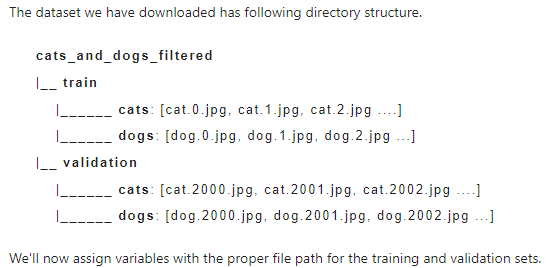

In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
     
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [5]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val
     

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


#### Setting Model Parameters
For convenience, let us set up variables that will be used later while pre-processing our dataset and training our network.

In [6]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

Batch size and image shape are two crucial hyperparameters that significantly impact the performance and efficiency of image classification with Convolutional Neural Networks (CNNs). Here's a breakdown of their implications:

Batch Size:

- Training Speed:
    - Larger batch sizes allow for faster training per epoch by performing a single weight update after processing a batch of images.
    - Smaller batch sizes require more weight updates per epoch due to smaller batches, leading to slower training but potentially better convergence.
- Generalization:
    - Larger batch sizes can lead to overfitting if the model focuses too much on specific patterns within the batch and fails to generalize well to unseen data.
    - Smaller batch sizes can help mitigate overfitting by exposing the model to more diverse samples during each update, potentially improving generalization.
- Memory Usage:
    - Larger batch sizes require more memory to store the images within a batch during training. This can be a limitation for resource-constrained environments.
    - Smaller batch sizes require less memory, making them suitable for training on devices with limited memory.

Image Shape:

- Model Complexity:
    - Larger image shapes (higher resolution) can capture more details but lead to a more complex model with more parameters. Training such models requires more data and computational resources.
    - Smaller image shapes (lower resolution) result in simpler models with fewer parameters. However, they might miss crucial details in the images, impacting performance.
- Performance:
    - Larger image shapes can potentially lead to better performance if the model can effectively utilize the additional information.
    - Smaller image shapes might lead to lower performance due to the loss of detailed information, especially for complex image classification tasks.
- Preprocessing Costs:
    - Larger image shapes require more processing power for resizing and normalization during data preprocessing.
    - Smaller image shapes require less processing power for preprocessing, making them faster to train on.

Finding the Optimal Balance:

Finding the optimal batch size and image shape depends on several factors, including:

- Dataset size: Larger datasets can often handle larger batch sizes without significant overfitting.
- Model architecture: More complex models might benefit from larger image shapes to capture more details.
- Computational resources: Limited memory or processing power might necessitate smaller batch sizes and image shapes.

Here are some general recommendations:

- Batch size: Experiment with different batch sizes (e.g., 32, 64, 128) and monitor validation performance to avoid overfitting.
- Image shape: Start with commonly used image sizes like 224x224 or 299x299, which work well for many pre-trained models. Adjust based on your dataset and performance.

Additional Tips:

- Consider using techniques like learning rate scheduling and data augmentation to improve generalization and potentially handle larger batch sizes.
- Leverage techniques like transfer learning with pre-trained models to reduce training complexity, especially when dealing with limited datasets.

By understanding the implications of batch size and image shape, you can effectively tune these hyperparameters to achieve optimal performance and efficiency for your image classification tasks with CNNs.

#### Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [7]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#### Flipping the image horizontally

In [8]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

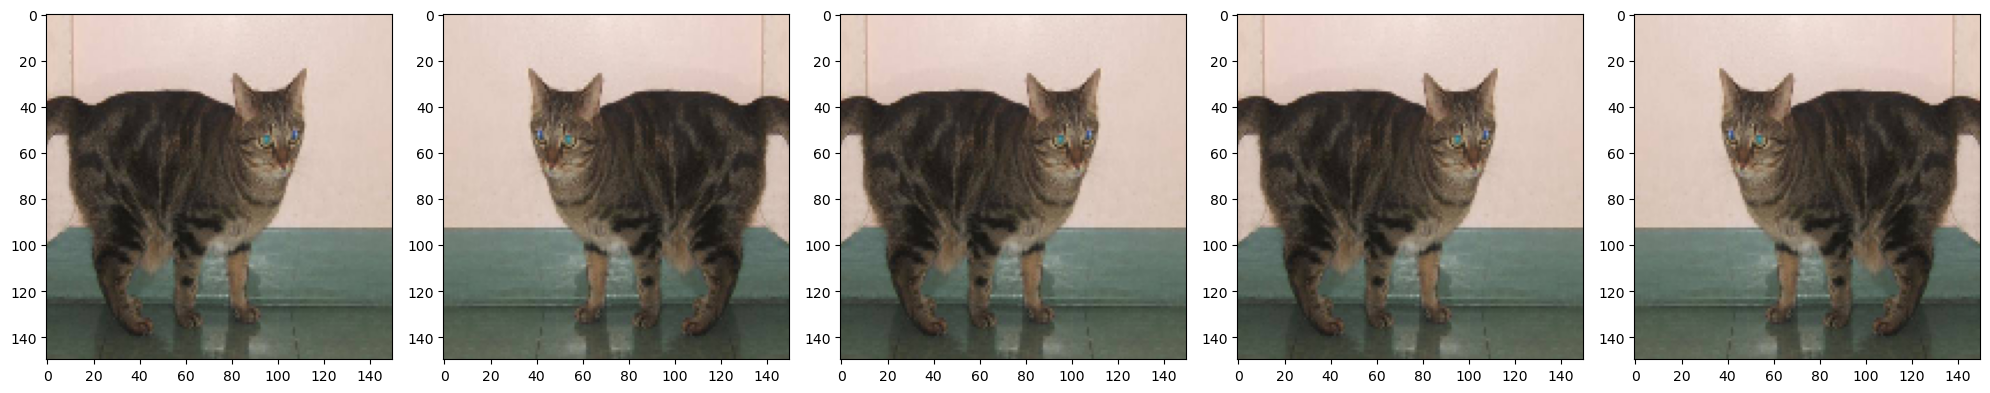

In [9]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Rotating the image
The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [10]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


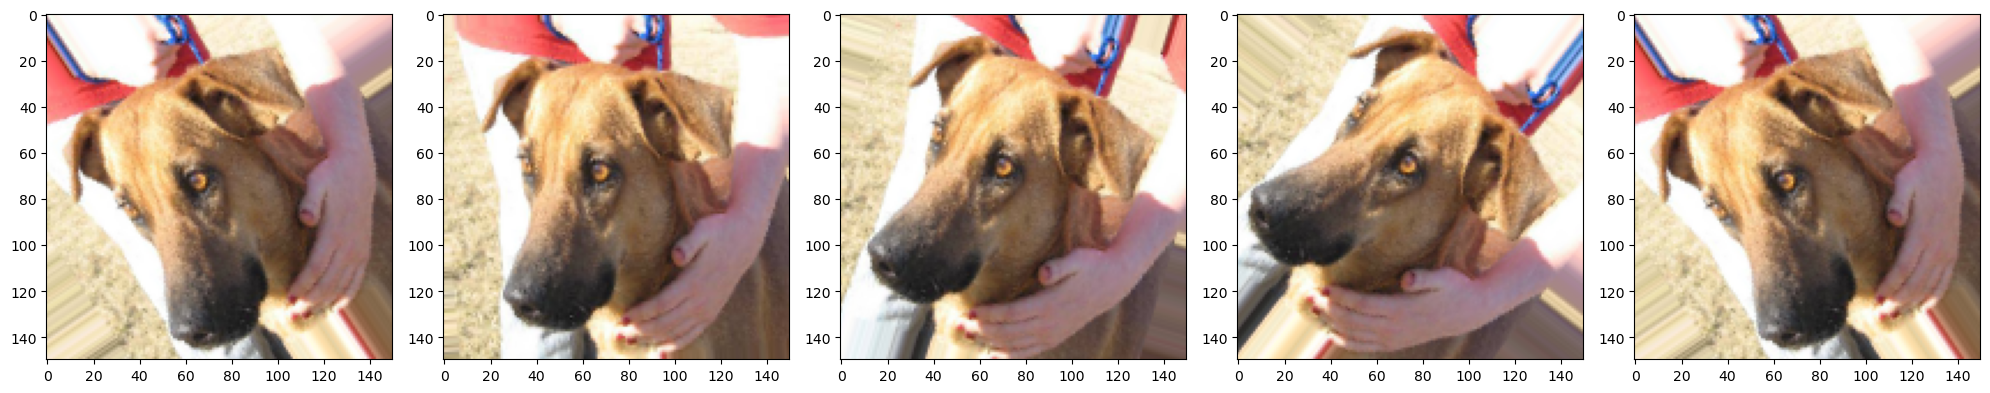

In [11]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Applying Zoom
We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

Found 2000 images belonging to 2 classes.


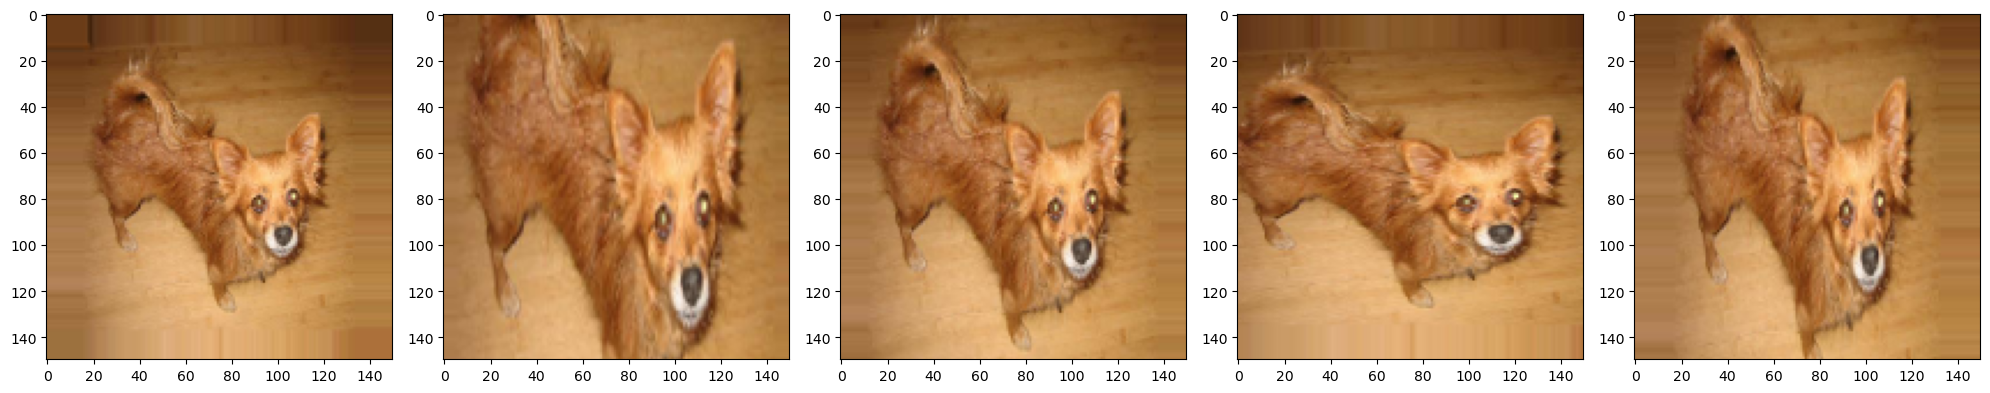

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Putting it all together
We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [13]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


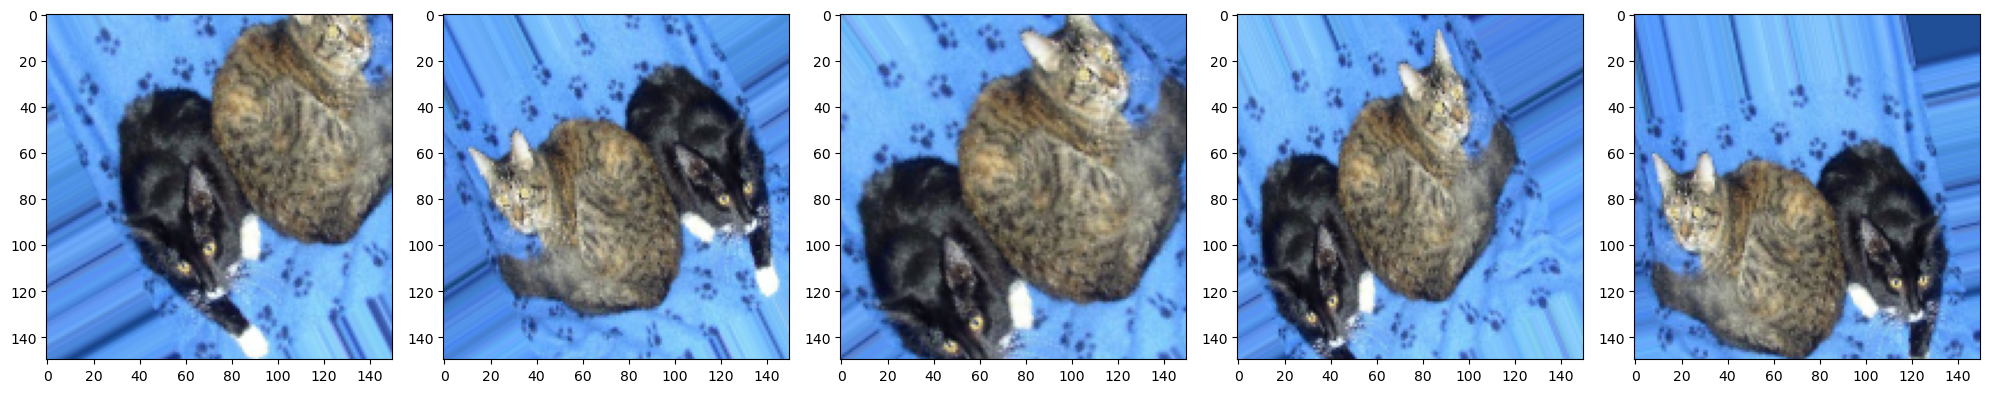

In [14]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Creating Validation Data generator
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator

In [15]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


#### Model Creation
##### Define the model
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5), #Added dropout layer - regularization technique for preventing overfitting
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

##### Compiling the model

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

#### Train the model
It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [19]:
epochs=20
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

C:\Users\ih371\AppData\Local\Temp\ipykernel_10208\711703578.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20


 4/20 [=====>........................] - ETA: 12s - loss: 0.7643 - accuracy: 0.4900

KeyboardInterrupt: 

#### Visualizing results of the training
We'll now visualize the results we get after training our network.

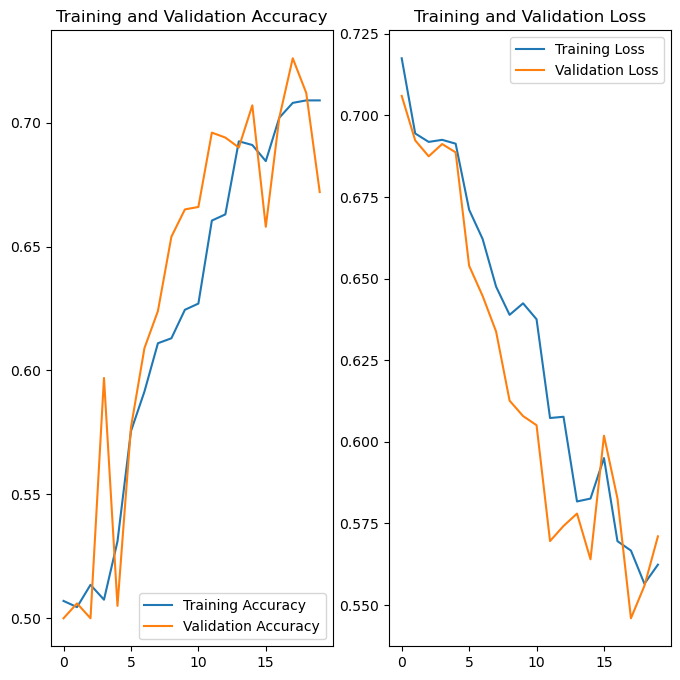

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 87ms/step


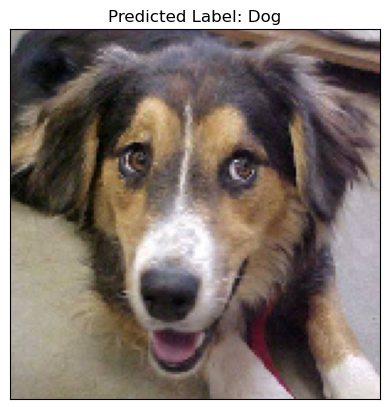

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a single batch of data
data, labels = next(val_data_gen)

first_image = data[0]  # Assuming the first image in the batch

# Make prediction on the first image
predictions = model.predict(np.expand_dims(first_image, axis=0))

# Decode the label
class_names = ['Cat','Dog']  # Replace with your class names
predicted_class = np.argmax(predictions[0])  # Index of the maximum value
predicted_label_text = class_names[predicted_class]

# Rescale the image data to a range of 0-1 for visualization
if np.max(first_image) > 1:
  first_image = first_image / 255.0  # Assuming image data is in range 0-255

# Plot the image
plt.imshow(first_image)
plt.title("Predicted Label: " + predicted_label_text)
plt.xticks([])
plt.yticks([])
plt.show()

1/1 [==============================] - 0s 16ms/step
[0.11557268 0.8844273 ]
1/1 [==============================] - 0s 15ms/step
[0.57515043 0.42484954]
1/1 [==============================] - 0s 16ms/step
[0.08990103 0.91009897]
1/1 [==============================] - 0s 17ms/step
[0.34390852 0.6560915 ]
1/1 [==============================] - 0s 16ms/step
[0.337363 0.662637]
1/1 [==============================] - 0s 16ms/step
[0.08369187 0.91630805]
1/1 [==============================] - 0s 16ms/step
[0.6631447  0.33685526]
1/1 [==============================] - 0s 16ms/step
[0.34671828 0.65328175]
1/1 [==============================] - 0s 15ms/step
[0.5745644  0.42543563]
1/1 [==============================] - 0s 15ms/step
[0.43131807 0.56868196]


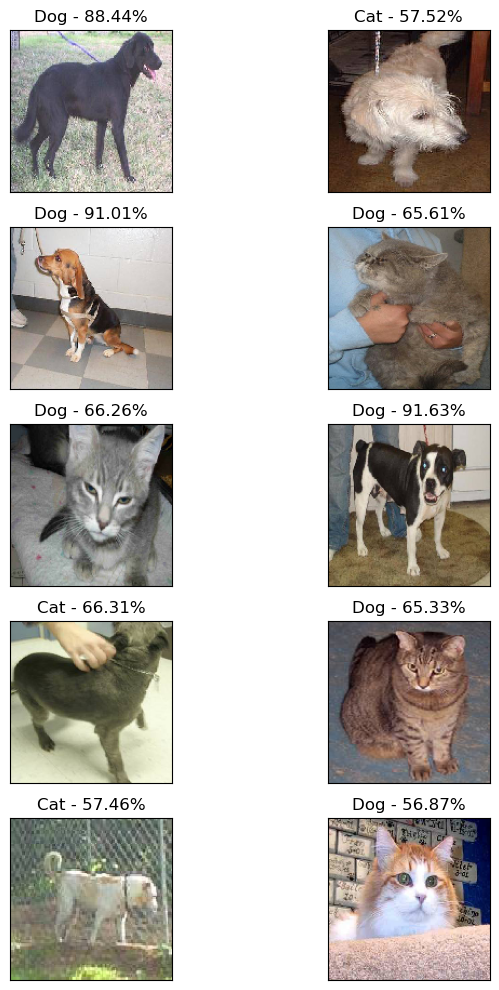

In [ ]:
# Get a batch of data
data, labels = next(val_data_gen)

num_images = 10  # Number of images to display
plt.figure(figsize=(8, 10))
# Loop through the first 10 images in the batch
for i in range(min(num_images, len(data))):
  current_image = data[i]
  current_label = labels[i]

  # Make prediction on the current image
  predictions = model.predict(np.expand_dims(current_image, axis=0))

  # Decode the one-hot encoded label and get confidence
  class_names = ['Cat', 'Dog']
  predicted_class = np.argmax(predictions[0])
  predicted_label_text = class_names[predicted_class]
  confidence = np.max(predictions[0]) * 100  # Convert confidence to percentage
  print(predictions[0])
  # Rescale the image data to a range of 0-1 for visualization
  if np.max(current_image) > 1:
    current_image = current_image / 255.0

  # Create a subplot and display the image with label and confidence
  plt.subplot(5, 2, i + 1)  # Arrange images in a 5x2 grid
  plt.imshow(current_image)
  plt.title(f"{predicted_label_text} - {confidence:.2f}%")  # Display label and confidence
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)  # Remove grid lines for better visualization

# Ensure the plot is displayed even if less than 10 images are available
plt.tight_layout()
plt.show()

#### Hyperparameter Tuning w/ optuna

In [ ]:
!pip install optuna

In [20]:
import optuna

In [34]:
def objective(trial):
    # Suggest activation functions for convolutional layers
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "leaky_relu"])
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])

    # Build the TensorFlow model using Keras functional API
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation=activation, input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3, 3), activation=activation),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Dropout(0.5),  # Added dropout layer for regularization
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    # Compile the model 
    model.compile(optimizer=optimizer, loss='SparseCategoricalCrossentropy', metrics=["accuracy"])

    # Train the model on your data (epochs are fixed at 10)
    history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=10,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
    )

    # Evaluate the model on your validation data
    val_acc = history.history.get('val_accuracy', None)[-1]

    # Return negative accuracy
    return -val_acc

In [35]:
study = optuna.create_study(direction="minimize")  # Minimize objective function (negative accuracy)


[I 2024-03-12 13:45:33,522] A new study created in memory with name: no-name-501aab6b-b896-4c4c-9934-7ba79c81f193


In [36]:
study.optimize(objective, n_trials=100)


C:\Users\ih371\AppData\Local\Temp\ipykernel_10208\3184611812.py:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
20/20 [==============================] - 13s 634ms/step - loss: 0.6929 - accuracy: 0.5055 - val_loss: 0.6919 - val_accuracy: 0.5280
Epoch 2/10
20/20 [==============================] - 12s 620ms/step - loss: 0.6923 - accuracy: 0.5255 - val_loss: 0.6910 - val_accuracy: 0.5110
Epoch 3/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6924 - accuracy: 0.5200 - val_loss: 0.6902 - val_accuracy: 0.5110
Epoch 4/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6917 - accuracy: 0.5220 - val_loss: 0.6898 - val_accuracy: 0.5130
Epoch 5/10
20/20 [==============================] - 12s 615ms/step - loss: 0.6913 - accuracy: 0.5270 - val_loss: 0.6892 - val_accuracy: 0.5090
Epoch 6/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6908 - accuracy: 0.5210 - val_loss: 0.6886 - val_accuracy: 0.5390
Epoch 7/10
20/20 [==============================] - 12s 617ms/step - loss: 0.6910 - accuracy: 0.5295 - val_loss: 0.6881 - val_accuracy: 0.5140

[I 2024-03-12 13:47:39,965] Trial 0 finished with value: -0.546999990940094 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 0 with value: -0.546999990940094.


Epoch 1/10
20/20 [==============================] - 14s 666ms/step - loss: 0.7055 - accuracy: 0.4975 - val_loss: 0.6967 - val_accuracy: 0.4620
Epoch 2/10
20/20 [==============================] - 13s 640ms/step - loss: 0.7008 - accuracy: 0.4965 - val_loss: 0.7002 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6960 - accuracy: 0.5195 - val_loss: 0.6918 - val_accuracy: 0.5050
Epoch 4/10
20/20 [==============================] - 13s 626ms/step - loss: 0.6950 - accuracy: 0.5235 - val_loss: 0.6882 - val_accuracy: 0.5270
Epoch 5/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6934 - accuracy: 0.5200 - val_loss: 0.6840 - val_accuracy: 0.5820
Epoch 6/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6902 - accuracy: 0.5350 - val_loss: 0.6815 - val_accuracy: 0.5900
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6923 - accuracy: 0.5190 - val_loss: 0.6807 - val_accuracy: 0.5660

[I 2024-03-12 13:49:44,882] Trial 1 finished with value: -0.5640000104904175 and parameters: {'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 1 with value: -0.5640000104904175.


Epoch 1/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6919 - accuracy: 0.5200 - val_loss: 0.6923 - val_accuracy: 0.5120
Epoch 2/10
20/20 [==============================] - 12s 589ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6919 - val_accuracy: 0.5040
Epoch 3/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6917 - accuracy: 0.5135 - val_loss: 0.6914 - val_accuracy: 0.5190
Epoch 4/10
20/20 [==============================] - 12s 591ms/step - loss: 0.6916 - accuracy: 0.5170 - val_loss: 0.6909 - val_accuracy: 0.5110
Epoch 5/10
20/20 [==============================] - 12s 579ms/step - loss: 0.6927 - accuracy: 0.5085 - val_loss: 0.6905 - val_accuracy: 0.5170
Epoch 6/10
20/20 [==============================] - 12s 581ms/step - loss: 0.6923 - accuracy: 0.5105 - val_loss: 0.6901 - val_accuracy: 0.5190
Epoch 7/10
20/20 [==============================] - 12s 581ms/step - loss: 0.6914 - accuracy: 0.5185 - val_loss: 0.6897 - val_accuracy: 0.5220

[I 2024-03-12 13:51:43,268] Trial 2 finished with value: -0.5360000133514404 and parameters: {'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 1 with value: -0.5640000104904175.


Epoch 1/10
20/20 [==============================] - 13s 621ms/step - loss: 1.1081 - accuracy: 0.4945 - val_loss: 0.6943 - val_accuracy: 0.5050
Epoch 2/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6941 - accuracy: 0.5135 - val_loss: 0.6923 - val_accuracy: 0.5110
Epoch 3/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6920 - accuracy: 0.5335 - val_loss: 0.6885 - val_accuracy: 0.5150
Epoch 4/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6859 - accuracy: 0.5450 - val_loss: 0.6768 - val_accuracy: 0.5640
Epoch 5/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6781 - accuracy: 0.5685 - val_loss: 0.6793 - val_accuracy: 0.5530
Epoch 6/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6818 - accuracy: 0.5570 - val_loss: 0.6750 - val_accuracy: 0.5710
Epoch 7/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6764 - accuracy: 0.5670 - val_loss: 0.7094 - val_accuracy: 0.5010

[I 2024-03-12 13:53:46,036] Trial 3 finished with value: -0.5170000195503235 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 1 with value: -0.5640000104904175.


Epoch 1/10
20/20 [==============================] - 13s 614ms/step - loss: 0.6979 - accuracy: 0.5145 - val_loss: 0.6907 - val_accuracy: 0.5080
Epoch 2/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6935 - accuracy: 0.5280 - val_loss: 0.6865 - val_accuracy: 0.5380
Epoch 3/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6922 - accuracy: 0.5285 - val_loss: 0.6827 - val_accuracy: 0.5730
Epoch 4/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6926 - accuracy: 0.5045 - val_loss: 0.6798 - val_accuracy: 0.5940
Epoch 5/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6876 - accuracy: 0.5395 - val_loss: 0.6773 - val_accuracy: 0.5830
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6875 - accuracy: 0.5480 - val_loss: 0.6759 - val_accuracy: 0.6060
Epoch 7/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6845 - accuracy: 0.5420 - val_loss: 0.6742 - val_accuracy: 0.5930

[I 2024-03-12 13:55:48,107] Trial 4 finished with value: -0.593999981880188 and parameters: {'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 4 with value: -0.593999981880188.


Epoch 1/10
20/20 [==============================] - 14s 623ms/step - loss: 1.1631 - accuracy: 0.4980 - val_loss: 0.6895 - val_accuracy: 0.5100
Epoch 2/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6870 - accuracy: 0.5570 - val_loss: 0.6797 - val_accuracy: 0.5290
Epoch 3/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6829 - accuracy: 0.5615 - val_loss: 0.6642 - val_accuracy: 0.6120
Epoch 4/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6803 - accuracy: 0.5595 - val_loss: 0.6594 - val_accuracy: 0.6120
Epoch 5/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6720 - accuracy: 0.5785 - val_loss: 0.6619 - val_accuracy: 0.5720
Epoch 6/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6706 - accuracy: 0.5715 - val_loss: 0.6796 - val_accuracy: 0.5340
Epoch 7/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6816 - accuracy: 0.5510 - val_loss: 0.6806 - val_accuracy: 0.5010

[I 2024-03-12 13:57:51,377] Trial 5 finished with value: -0.6480000019073486 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 5 with value: -0.6480000019073486.


Epoch 1/10
20/20 [==============================] - 13s 618ms/step - loss: 0.7198 - accuracy: 0.4920 - val_loss: 0.6916 - val_accuracy: 0.5920
Epoch 2/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6915 - accuracy: 0.5220 - val_loss: 0.6863 - val_accuracy: 0.5320
Epoch 3/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6728 - accuracy: 0.5800 - val_loss: 0.6702 - val_accuracy: 0.5540
Epoch 4/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6657 - accuracy: 0.6040 - val_loss: 0.6382 - val_accuracy: 0.6250
Epoch 5/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6526 - accuracy: 0.6180 - val_loss: 0.6047 - val_accuracy: 0.6750
Epoch 6/10
20/20 [==============================] - 12s 623ms/step - loss: 0.6549 - accuracy: 0.6065 - val_loss: 0.6452 - val_accuracy: 0.6030
Epoch 7/10
20/20 [==============================] - 12s 621ms/step - loss: 0.6571 - accuracy: 0.6010 - val_loss: 0.6174 - val_accuracy: 0.6670

[I 2024-03-12 13:59:56,340] Trial 6 finished with value: -0.6549999713897705 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 6 with value: -0.6549999713897705.


Epoch 1/10
20/20 [==============================] - 13s 604ms/step - loss: 0.6938 - accuracy: 0.5080 - val_loss: 0.6937 - val_accuracy: 0.4760
Epoch 2/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 586ms/step - loss: 0.6923 - accuracy: 0.5085 - val_loss: 0.6922 - val_accuracy: 0.5110
Epoch 4/10
20/20 [==============================] - 12s 587ms/step - loss: 0.6920 - accuracy: 0.5080 - val_loss: 0.6918 - val_accuracy: 0.5040
Epoch 5/10
20/20 [==============================] - 12s 587ms/step - loss: 0.6913 - accuracy: 0.5205 - val_loss: 0.6912 - val_accuracy: 0.5080
Epoch 6/10
20/20 [==============================] - 12s 590ms/step - loss: 0.6921 - accuracy: 0.5190 - val_loss: 0.6906 - val_accuracy: 0.5160
Epoch 7/10
20/20 [==============================] - 12s 587ms/step - loss: 0.6903 - accuracy: 0.5265 - val_loss: 0.6901 - val_accuracy: 0.5290

[I 2024-03-12 14:01:55,669] Trial 7 finished with value: -0.5180000066757202 and parameters: {'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 6 with value: -0.6549999713897705.


Epoch 1/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6955 - accuracy: 0.5175 - val_loss: 0.6925 - val_accuracy: 0.5190
Epoch 2/10
20/20 [==============================] - 12s 625ms/step - loss: 0.6935 - accuracy: 0.5085 - val_loss: 0.6898 - val_accuracy: 0.5190
Epoch 3/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6914 - accuracy: 0.5280 - val_loss: 0.6854 - val_accuracy: 0.5370
Epoch 4/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6874 - accuracy: 0.5480 - val_loss: 0.6832 - val_accuracy: 0.5450
Epoch 5/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6828 - accuracy: 0.5585 - val_loss: 0.6777 - val_accuracy: 0.6000
Epoch 6/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6857 - accuracy: 0.5450 - val_loss: 0.6939 - val_accuracy: 0.5010
Epoch 7/10
20/20 [==============================] - 12s 615ms/step - loss: 0.6860 - accuracy: 0.5420 - val_loss: 0.6835 - val_accuracy: 0.5250

[I 2024-03-12 14:04:00,005] Trial 8 finished with value: -0.5789999961853027 and parameters: {'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 6 with value: -0.6549999713897705.


Epoch 1/10
20/20 [==============================] - 13s 618ms/step - loss: 0.6949 - accuracy: 0.5210 - val_loss: 0.6984 - val_accuracy: 0.5010
Epoch 2/10
20/20 [==============================] - 12s 601ms/step - loss: 0.7006 - accuracy: 0.4855 - val_loss: 0.6901 - val_accuracy: 0.5110
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6956 - accuracy: 0.5095 - val_loss: 0.6919 - val_accuracy: 0.5060
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6953 - accuracy: 0.5155 - val_loss: 0.6880 - val_accuracy: 0.5090
Epoch 5/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6924 - accuracy: 0.5140 - val_loss: 0.6860 - val_accuracy: 0.5170
Epoch 6/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6801 - val_accuracy: 0.5730
Epoch 7/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6877 - accuracy: 0.5370 - val_loss: 0.6838 - val_accuracy: 0.5140

[I 2024-03-12 14:06:01,890] Trial 9 finished with value: -0.5120000243186951 and parameters: {'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 6 with value: -0.6549999713897705.


Epoch 1/10
20/20 [==============================] - 14s 641ms/step - loss: 0.7156 - accuracy: 0.5180 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6861 - accuracy: 0.5315 - val_loss: 0.6546 - val_accuracy: 0.6080
Epoch 3/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6683 - accuracy: 0.5660 - val_loss: 0.6542 - val_accuracy: 0.6030
Epoch 4/10
20/20 [==============================] - 12s 620ms/step - loss: 0.6651 - accuracy: 0.5765 - val_loss: 0.6351 - val_accuracy: 0.6350
Epoch 5/10
20/20 [==============================] - 12s 623ms/step - loss: 0.6515 - accuracy: 0.5990 - val_loss: 0.6404 - val_accuracy: 0.6160
Epoch 6/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6488 - accuracy: 0.6040 - val_loss: 0.6644 - val_accuracy: 0.5870
Epoch 7/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6223 - accuracy: 0.6510 - val_loss: 0.5936 - val_accuracy: 0.6810

[I 2024-03-12 14:08:08,491] Trial 10 finished with value: -0.7070000171661377 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 10 with value: -0.7070000171661377.


Epoch 1/10
20/20 [==============================] - 14s 633ms/step - loss: 0.7156 - accuracy: 0.5000 - val_loss: 0.6936 - val_accuracy: 0.5010
Epoch 2/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6927 - accuracy: 0.5120 - val_loss: 0.6904 - val_accuracy: 0.5220
Epoch 3/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6950 - accuracy: 0.5010 - val_loss: 0.6891 - val_accuracy: 0.5490
Epoch 4/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6919 - accuracy: 0.5155 - val_loss: 0.6896 - val_accuracy: 0.5470
Epoch 5/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6848 - accuracy: 0.5625 - val_loss: 0.6615 - val_accuracy: 0.5340
Epoch 6/10
20/20 [==============================] - 12s 616ms/step - loss: 0.6961 - accuracy: 0.5315 - val_loss: 0.6924 - val_accuracy: 0.5050
Epoch 7/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6896 - accuracy: 0.5260 - val_loss: 0.6880 - val_accuracy: 0.5030

[I 2024-03-12 14:10:13,131] Trial 11 finished with value: -0.621999979019165 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 10 with value: -0.7070000171661377.


Epoch 1/10
20/20 [==============================] - 13s 620ms/step - loss: 0.7102 - accuracy: 0.5160 - val_loss: 0.7060 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6877 - accuracy: 0.5405 - val_loss: 0.6759 - val_accuracy: 0.5210
Epoch 3/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6730 - accuracy: 0.5765 - val_loss: 0.6661 - val_accuracy: 0.5520
Epoch 4/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6764 - accuracy: 0.5690 - val_loss: 0.6670 - val_accuracy: 0.5100
Epoch 5/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6710 - accuracy: 0.5810 - val_loss: 0.6360 - val_accuracy: 0.6280
Epoch 6/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6659 - accuracy: 0.5900 - val_loss: 0.6252 - val_accuracy: 0.6440
Epoch 7/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6550 - accuracy: 0.5945 - val_loss: 0.6211 - val_accuracy: 0.6320

[I 2024-03-12 14:12:16,535] Trial 12 finished with value: -0.6790000200271606 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 10 with value: -0.7070000171661377.


Epoch 1/10
20/20 [==============================] - 14s 621ms/step - loss: 0.7264 - accuracy: 0.4955 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6950 - accuracy: 0.5210 - val_loss: 0.6880 - val_accuracy: 0.5940
Epoch 3/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6899 - accuracy: 0.5285 - val_loss: 0.6754 - val_accuracy: 0.6090
Epoch 4/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6764 - accuracy: 0.5870 - val_loss: 0.6756 - val_accuracy: 0.5840
Epoch 5/10
20/20 [==============================] - 12s 616ms/step - loss: 0.6846 - accuracy: 0.5440 - val_loss: 0.6679 - val_accuracy: 0.5360
Epoch 6/10
20/20 [==============================] - 12s 614ms/step - loss: 0.6767 - accuracy: 0.5615 - val_loss: 0.6662 - val_accuracy: 0.5350
Epoch 7/10
20/20 [==============================] - 12s 614ms/step - loss: 0.6638 - accuracy: 0.5815 - val_loss: 0.6416 - val_accuracy: 0.6230

[I 2024-03-12 14:14:20,733] Trial 13 finished with value: -0.6700000166893005 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 10 with value: -0.7070000171661377.


Epoch 1/10
20/20 [==============================] - 13s 620ms/step - loss: 0.7103 - accuracy: 0.5250 - val_loss: 0.6791 - val_accuracy: 0.5150
Epoch 2/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6865 - accuracy: 0.5365 - val_loss: 0.6682 - val_accuracy: 0.5020
Epoch 3/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6726 - accuracy: 0.5840 - val_loss: 0.6733 - val_accuracy: 0.5110
Epoch 4/10
20/20 [==============================] - 12s 620ms/step - loss: 0.6606 - accuracy: 0.5855 - val_loss: 0.6232 - val_accuracy: 0.6500
Epoch 5/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6566 - accuracy: 0.5960 - val_loss: 0.6171 - val_accuracy: 0.6490
Epoch 6/10
20/20 [==============================] - 14s 685ms/step - loss: 0.6408 - accuracy: 0.6300 - val_loss: 0.5993 - val_accuracy: 0.6640
Epoch 7/10
20/20 [==============================] - 13s 640ms/step - loss: 0.6213 - accuracy: 0.6555 - val_loss: 0.5938 - val_accuracy: 0.6840

[I 2024-03-12 14:16:27,938] Trial 14 finished with value: -0.718999981880188 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 638ms/step - loss: 0.7340 - accuracy: 0.5205 - val_loss: 0.6698 - val_accuracy: 0.5830
Epoch 2/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6861 - accuracy: 0.5470 - val_loss: 0.6825 - val_accuracy: 0.5020
Epoch 3/10
20/20 [==============================] - 13s 626ms/step - loss: 0.7067 - accuracy: 0.5275 - val_loss: 0.6844 - val_accuracy: 0.4990
Epoch 4/10
20/20 [==============================] - 13s 626ms/step - loss: 0.6857 - accuracy: 0.5350 - val_loss: 0.6588 - val_accuracy: 0.6060
Epoch 5/10
20/20 [==============================] - 13s 625ms/step - loss: 0.6809 - accuracy: 0.5900 - val_loss: 0.6910 - val_accuracy: 0.5250
Epoch 6/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6680 - accuracy: 0.5820 - val_loss: 0.6379 - val_accuracy: 0.6190
Epoch 7/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6548 - accuracy: 0.6010 - val_loss: 0.6355 - val_accuracy: 0.5810

[I 2024-03-12 14:18:34,837] Trial 15 finished with value: -0.6940000057220459 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 634ms/step - loss: 0.7481 - accuracy: 0.4785 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6937 - accuracy: 0.5005 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 621ms/step - loss: 0.6904 - accuracy: 0.5310 - val_loss: 0.6787 - val_accuracy: 0.5780
Epoch 4/10
20/20 [==============================] - 13s 639ms/step - loss: 0.6881 - accuracy: 0.5440 - val_loss: 0.6867 - val_accuracy: 0.5240
Epoch 5/10
20/20 [==============================] - 13s 648ms/step - loss: 0.6832 - accuracy: 0.5535 - val_loss: 0.7646 - val_accuracy: 0.5090
Epoch 6/10
20/20 [==============================] - 13s 640ms/step - loss: 0.6667 - accuracy: 0.5810 - val_loss: 0.6692 - val_accuracy: 0.5520
Epoch 7/10
20/20 [==============================] - 13s 643ms/step - loss: 0.6703 - accuracy: 0.5715 - val_loss: 0.6703 - val_accuracy: 0.5610

[I 2024-03-12 14:20:43,562] Trial 16 finished with value: -0.6510000228881836 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 649ms/step - loss: 0.7473 - accuracy: 0.4930 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 641ms/step - loss: 0.6943 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 13s 642ms/step - loss: 0.6941 - accuracy: 0.4945 - val_loss: 0.6926 - val_accuracy: 0.5760
Epoch 4/10
20/20 [==============================] - 13s 637ms/step - loss: 0.6925 - accuracy: 0.5425 - val_loss: 0.6890 - val_accuracy: 0.5910
Epoch 5/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6907 - accuracy: 0.5505 - val_loss: 0.6855 - val_accuracy: 0.5070
Epoch 6/10
20/20 [==============================] - 13s 634ms/step - loss: 0.6855 - accuracy: 0.5590 - val_loss: 0.6744 - val_accuracy: 0.5730
Epoch 7/10
20/20 [==============================] - 13s 636ms/step - loss: 0.6768 - accuracy: 0.5725 - val_loss: 0.6981 - val_accuracy: 0.5150

[I 2024-03-12 14:22:52,758] Trial 17 finished with value: -0.6589999794960022 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 617ms/step - loss: 0.7360 - accuracy: 0.4850 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6916 - accuracy: 0.5125 - val_loss: 0.6918 - val_accuracy: 0.5210
Epoch 3/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6903 - accuracy: 0.5335 - val_loss: 0.6805 - val_accuracy: 0.5340
Epoch 4/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6727 - accuracy: 0.5895 - val_loss: 0.6842 - val_accuracy: 0.5330
Epoch 5/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6824 - accuracy: 0.5620 - val_loss: 0.6670 - val_accuracy: 0.6120
Epoch 6/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6687 - accuracy: 0.5985 - val_loss: 0.6380 - val_accuracy: 0.6140
Epoch 7/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6598 - accuracy: 0.6050 - val_loss: 0.6464 - val_accuracy: 0.6530

[I 2024-03-12 14:24:55,307] Trial 18 finished with value: -0.6610000133514404 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 637ms/step - loss: 0.7426 - accuracy: 0.4980 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 2/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6960 - accuracy: 0.5060 - val_loss: 0.6964 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 623ms/step - loss: 0.6923 - accuracy: 0.5215 - val_loss: 0.6913 - val_accuracy: 0.5050
Epoch 4/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6926 - accuracy: 0.5015 - val_loss: 0.6881 - val_accuracy: 0.5050
Epoch 5/10
20/20 [==============================] - 13s 652ms/step - loss: 0.6884 - accuracy: 0.5270 - val_loss: 0.6780 - val_accuracy: 0.6090
Epoch 6/10
20/20 [==============================] - 14s 683ms/step - loss: 0.6818 - accuracy: 0.5395 - val_loss: 0.6577 - val_accuracy: 0.5820
Epoch 7/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6969 - accuracy: 0.5365 - val_loss: 0.7076 - val_accuracy: 0.5000

[I 2024-03-12 14:27:03,958] Trial 19 finished with value: -0.5680000185966492 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 646ms/step - loss: 0.7267 - accuracy: 0.5155 - val_loss: 0.6728 - val_accuracy: 0.5970
Epoch 2/10
20/20 [==============================] - 13s 643ms/step - loss: 0.6971 - accuracy: 0.5130 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 13s 636ms/step - loss: 0.6909 - accuracy: 0.5095 - val_loss: 0.6844 - val_accuracy: 0.5670
Epoch 4/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6931 - accuracy: 0.5100 - val_loss: 0.6902 - val_accuracy: 0.5230
Epoch 5/10
20/20 [==============================] - 13s 634ms/step - loss: 0.6902 - accuracy: 0.5320 - val_loss: 0.6813 - val_accuracy: 0.5950
Epoch 6/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6886 - accuracy: 0.5530 - val_loss: 0.6735 - val_accuracy: 0.6000
Epoch 7/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6747 - accuracy: 0.5780 - val_loss: 0.6626 - val_accuracy: 0.5970

[I 2024-03-12 14:29:12,817] Trial 20 finished with value: -0.5929999947547913 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 635ms/step - loss: 0.7148 - accuracy: 0.5080 - val_loss: 0.6916 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6913 - accuracy: 0.5160 - val_loss: 0.6813 - val_accuracy: 0.6050
Epoch 3/10
20/20 [==============================] - 12s 625ms/step - loss: 0.6766 - accuracy: 0.5645 - val_loss: 0.6581 - val_accuracy: 0.6040
Epoch 4/10
20/20 [==============================] - 13s 641ms/step - loss: 0.6715 - accuracy: 0.5795 - val_loss: 0.6574 - val_accuracy: 0.6150
Epoch 5/10
20/20 [==============================] - 13s 629ms/step - loss: 0.6623 - accuracy: 0.5825 - val_loss: 0.6721 - val_accuracy: 0.5550
Epoch 6/10
20/20 [==============================] - 13s 629ms/step - loss: 0.6499 - accuracy: 0.6025 - val_loss: 0.7189 - val_accuracy: 0.5770
Epoch 7/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6485 - accuracy: 0.6080 - val_loss: 0.6466 - val_accuracy: 0.6000

[I 2024-03-12 14:31:19,806] Trial 21 finished with value: -0.699999988079071 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 637ms/step - loss: 0.7305 - accuracy: 0.5140 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 2/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6970 - accuracy: 0.4900 - val_loss: 0.6930 - val_accuracy: 0.4990
Epoch 3/10
20/20 [==============================] - 12s 617ms/step - loss: 0.6937 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 13s 651ms/step - loss: 0.6940 - accuracy: 0.5060 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 14s 698ms/step - loss: 0.6936 - accuracy: 0.4915 - val_loss: 0.6917 - val_accuracy: 0.5670
Epoch 6/10
20/20 [==============================] - 13s 647ms/step - loss: 0.6909 - accuracy: 0.5285 - val_loss: 0.6848 - val_accuracy: 0.5820
Epoch 7/10
20/20 [==============================] - 13s 643ms/step - loss: 0.6857 - accuracy: 0.5505 - val_loss: 0.6684 - val_accuracy: 0.6000

[I 2024-03-12 14:33:29,677] Trial 22 finished with value: -0.6169999837875366 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 647ms/step - loss: 0.7391 - accuracy: 0.5130 - val_loss: 0.7027 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6949 - accuracy: 0.5185 - val_loss: 0.6878 - val_accuracy: 0.5790
Epoch 3/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6859 - accuracy: 0.5465 - val_loss: 0.6692 - val_accuracy: 0.5890
Epoch 4/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6827 - accuracy: 0.5520 - val_loss: 0.6593 - val_accuracy: 0.6060
Epoch 5/10
20/20 [==============================] - 13s 632ms/step - loss: 0.6839 - accuracy: 0.5660 - val_loss: 0.6780 - val_accuracy: 0.6190
Epoch 6/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6763 - accuracy: 0.5560 - val_loss: 0.6435 - val_accuracy: 0.6390
Epoch 7/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6757 - accuracy: 0.5780 - val_loss: 0.6605 - val_accuracy: 0.5700

[I 2024-03-12 14:35:37,576] Trial 23 finished with value: -0.6669999957084656 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 642ms/step - loss: 0.7111 - accuracy: 0.5150 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 630ms/step - loss: 0.7051 - accuracy: 0.5420 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6933 - accuracy: 0.5135 - val_loss: 0.6906 - val_accuracy: 0.5800
Epoch 4/10
20/20 [==============================] - 13s 636ms/step - loss: 0.6918 - accuracy: 0.5440 - val_loss: 0.6905 - val_accuracy: 0.5130
Epoch 5/10
20/20 [==============================] - 13s 644ms/step - loss: 0.6940 - accuracy: 0.5025 - val_loss: 0.6907 - val_accuracy: 0.5190
Epoch 6/10
20/20 [==============================] - 13s 649ms/step - loss: 0.6887 - accuracy: 0.5530 - val_loss: 0.6712 - val_accuracy: 0.6210
Epoch 7/10
20/20 [==============================] - 13s 648ms/step - loss: 0.6802 - accuracy: 0.5735 - val_loss: 0.6611 - val_accuracy: 0.5930

[I 2024-03-12 14:37:47,623] Trial 24 finished with value: -0.6499999761581421 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 628ms/step - loss: 0.7047 - accuracy: 0.5120 - val_loss: 0.6881 - val_accuracy: 0.5480
Epoch 2/10
20/20 [==============================] - 12s 620ms/step - loss: 0.6927 - accuracy: 0.5310 - val_loss: 0.6892 - val_accuracy: 0.6110
Epoch 3/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6912 - accuracy: 0.5155 - val_loss: 0.6839 - val_accuracy: 0.6260
Epoch 4/10
20/20 [==============================] - 13s 628ms/step - loss: 0.6881 - accuracy: 0.5390 - val_loss: 0.6924 - val_accuracy: 0.5120
Epoch 5/10
20/20 [==============================] - 13s 649ms/step - loss: 0.6930 - accuracy: 0.5080 - val_loss: 0.6910 - val_accuracy: 0.5360
Epoch 6/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6896 - accuracy: 0.5175 - val_loss: 0.6825 - val_accuracy: 0.5550
Epoch 7/10
20/20 [==============================] - 13s 636ms/step - loss: 0.6906 - accuracy: 0.5370 - val_loss: 0.6890 - val_accuracy: 0.5010

[I 2024-03-12 14:39:53,653] Trial 25 finished with value: -0.6159999966621399 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 645ms/step - loss: 0.7612 - accuracy: 0.4980 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6932 - accuracy: 0.5040 - val_loss: 0.7092 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6948 - accuracy: 0.5065 - val_loss: 0.6971 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6922 - accuracy: 0.5235 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 620ms/step - loss: 0.6906 - accuracy: 0.5500 - val_loss: 0.6850 - val_accuracy: 0.5970
Epoch 6/10
20/20 [==============================] - 13s 628ms/step - loss: 0.6902 - accuracy: 0.5280 - val_loss: 0.6810 - val_accuracy: 0.6020
Epoch 7/10
20/20 [==============================] - 13s 648ms/step - loss: 0.6780 - accuracy: 0.5670 - val_loss: 0.6661 - val_accuracy: 0.6040

[I 2024-03-12 14:42:01,611] Trial 26 finished with value: -0.5400000214576721 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 643ms/step - loss: 0.7056 - accuracy: 0.5160 - val_loss: 0.6819 - val_accuracy: 0.5020
Epoch 2/10
20/20 [==============================] - 13s 626ms/step - loss: 0.6744 - accuracy: 0.5575 - val_loss: 0.6357 - val_accuracy: 0.6140
Epoch 3/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6741 - accuracy: 0.5830 - val_loss: 0.6451 - val_accuracy: 0.6160
Epoch 4/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6525 - accuracy: 0.6145 - val_loss: 0.6353 - val_accuracy: 0.6210
Epoch 5/10
20/20 [==============================] - 13s 638ms/step - loss: 0.6434 - accuracy: 0.6290 - val_loss: 0.5881 - val_accuracy: 0.6960
Epoch 6/10
20/20 [==============================] - 13s 629ms/step - loss: 0.6284 - accuracy: 0.6415 - val_loss: 0.5889 - val_accuracy: 0.6970
Epoch 7/10
20/20 [==============================] - 13s 637ms/step - loss: 0.6027 - accuracy: 0.6735 - val_loss: 0.5861 - val_accuracy: 0.6810

[I 2024-03-12 14:44:11,093] Trial 27 finished with value: -0.7059999704360962 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 15s 663ms/step - loss: 0.7389 - accuracy: 0.5075 - val_loss: 0.6831 - val_accuracy: 0.5790
Epoch 2/10
20/20 [==============================] - 13s 656ms/step - loss: 0.6946 - accuracy: 0.5125 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 13s 649ms/step - loss: 0.6945 - accuracy: 0.5025 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 13s 651ms/step - loss: 0.6923 - accuracy: 0.5225 - val_loss: 0.6839 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 13s 648ms/step - loss: 0.6818 - accuracy: 0.5545 - val_loss: 0.6929 - val_accuracy: 0.5410
Epoch 6/10
20/20 [==============================] - 13s 649ms/step - loss: 0.6847 - accuracy: 0.5380 - val_loss: 0.6524 - val_accuracy: 0.6270
Epoch 7/10
20/20 [==============================] - 13s 647ms/step - loss: 0.6744 - accuracy: 0.5700 - val_loss: 0.6666 - val_accuracy: 0.5800

[I 2024-03-12 14:46:23,048] Trial 28 finished with value: -0.6200000047683716 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 652ms/step - loss: 0.7368 - accuracy: 0.5130 - val_loss: 0.6858 - val_accuracy: 0.5330
Epoch 2/10
20/20 [==============================] - 13s 645ms/step - loss: 0.6895 - accuracy: 0.5325 - val_loss: 0.6812 - val_accuracy: 0.5450
Epoch 3/10
20/20 [==============================] - 13s 642ms/step - loss: 0.6849 - accuracy: 0.5560 - val_loss: 0.6804 - val_accuracy: 0.5460
Epoch 4/10
20/20 [==============================] - 13s 644ms/step - loss: 0.6797 - accuracy: 0.5780 - val_loss: 0.6650 - val_accuracy: 0.6160
Epoch 5/10
20/20 [==============================] - 13s 644ms/step - loss: 0.6706 - accuracy: 0.5965 - val_loss: 0.6421 - val_accuracy: 0.6350
Epoch 6/10
20/20 [==============================] - 13s 642ms/step - loss: 0.6606 - accuracy: 0.6000 - val_loss: 0.6236 - val_accuracy: 0.6510
Epoch 7/10
20/20 [==============================] - 13s 645ms/step - loss: 0.6446 - accuracy: 0.6160 - val_loss: 0.5802 - val_accuracy: 0.6980

[I 2024-03-12 14:48:33,520] Trial 29 finished with value: -0.6930000185966492 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 626ms/step - loss: 0.7104 - accuracy: 0.4875 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6906 - accuracy: 0.5115 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 578ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6898 - val_accuracy: 0.5900
Epoch 4/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6803 - accuracy: 0.5600 - val_loss: 0.6452 - val_accuracy: 0.6230
Epoch 5/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6726 - accuracy: 0.5610 - val_loss: 0.6472 - val_accuracy: 0.5870
Epoch 6/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6646 - accuracy: 0.5920 - val_loss: 0.6330 - val_accuracy: 0.6430
Epoch 7/10
20/20 [==============================] - 11s 573ms/step - loss: 0.6507 - accuracy: 0.5990 - val_loss: 0.6747 - val_accuracy: 0.5280

[I 2024-03-12 14:50:33,410] Trial 30 finished with value: -0.6399999856948853 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 640ms/step - loss: 0.7221 - accuracy: 0.5305 - val_loss: 0.6891 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 637ms/step - loss: 0.6868 - accuracy: 0.5375 - val_loss: 0.6777 - val_accuracy: 0.6010
Epoch 3/10
20/20 [==============================] - 13s 636ms/step - loss: 0.6888 - accuracy: 0.5185 - val_loss: 0.6853 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 13s 632ms/step - loss: 0.6838 - accuracy: 0.5485 - val_loss: 0.6692 - val_accuracy: 0.5520
Epoch 5/10
20/20 [==============================] - 13s 634ms/step - loss: 0.6686 - accuracy: 0.5955 - val_loss: 0.6387 - val_accuracy: 0.6380
Epoch 6/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6716 - accuracy: 0.5690 - val_loss: 0.6199 - val_accuracy: 0.6410
Epoch 7/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6473 - accuracy: 0.6255 - val_loss: 0.6002 - val_accuracy: 0.6690

[I 2024-03-12 14:52:41,742] Trial 31 finished with value: -0.6800000071525574 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 656ms/step - loss: 0.7272 - accuracy: 0.5185 - val_loss: 0.6872 - val_accuracy: 0.5700
Epoch 2/10
20/20 [==============================] - 13s 656ms/step - loss: 0.6822 - accuracy: 0.5430 - val_loss: 0.6614 - val_accuracy: 0.5800
Epoch 3/10
20/20 [==============================] - 14s 675ms/step - loss: 0.6704 - accuracy: 0.5595 - val_loss: 0.6695 - val_accuracy: 0.5660
Epoch 4/10
20/20 [==============================] - 13s 664ms/step - loss: 0.6571 - accuracy: 0.6100 - val_loss: 0.6296 - val_accuracy: 0.6410
Epoch 5/10
20/20 [==============================] - 13s 645ms/step - loss: 0.6310 - accuracy: 0.6450 - val_loss: 0.6239 - val_accuracy: 0.6480
Epoch 6/10
20/20 [==============================] - 13s 644ms/step - loss: 0.6265 - accuracy: 0.6485 - val_loss: 0.6203 - val_accuracy: 0.6600
Epoch 7/10
20/20 [==============================] - 13s 639ms/step - loss: 0.6126 - accuracy: 0.6610 - val_loss: 0.6018 - val_accuracy: 0.6690

[I 2024-03-12 14:54:53,565] Trial 32 finished with value: -0.6940000057220459 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 643ms/step - loss: 0.7671 - accuracy: 0.5020 - val_loss: 0.6928 - val_accuracy: 0.4990
Epoch 2/10
20/20 [==============================] - 13s 634ms/step - loss: 0.6927 - accuracy: 0.5080 - val_loss: 0.6887 - val_accuracy: 0.5770
Epoch 3/10
20/20 [==============================] - 13s 633ms/step - loss: 0.6924 - accuracy: 0.5245 - val_loss: 0.6905 - val_accuracy: 0.5060
Epoch 4/10
20/20 [==============================] - 13s 632ms/step - loss: 0.6912 - accuracy: 0.5250 - val_loss: 0.6857 - val_accuracy: 0.5240
Epoch 5/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6854 - accuracy: 0.5455 - val_loss: 0.6845 - val_accuracy: 0.5100
Epoch 6/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6648 - accuracy: 0.5950 - val_loss: 0.6691 - val_accuracy: 0.5850
Epoch 7/10
20/20 [==============================] - 13s 632ms/step - loss: 0.6780 - accuracy: 0.5960 - val_loss: 0.6600 - val_accuracy: 0.6100

[I 2024-03-12 14:57:01,825] Trial 33 finished with value: -0.6129999756813049 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 642ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6928 - val_accuracy: 0.5170
Epoch 2/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6926 - accuracy: 0.5105 - val_loss: 0.6922 - val_accuracy: 0.5290
Epoch 3/10
20/20 [==============================] - 13s 628ms/step - loss: 0.6942 - accuracy: 0.4835 - val_loss: 0.6917 - val_accuracy: 0.5300
Epoch 4/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6929 - accuracy: 0.5040 - val_loss: 0.6911 - val_accuracy: 0.5220
Epoch 5/10
20/20 [==============================] - 13s 628ms/step - loss: 0.6929 - accuracy: 0.5120 - val_loss: 0.6907 - val_accuracy: 0.5240
Epoch 6/10
20/20 [==============================] - 13s 626ms/step - loss: 0.6928 - accuracy: 0.5010 - val_loss: 0.6903 - val_accuracy: 0.5230
Epoch 7/10
20/20 [==============================] - 13s 626ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6902 - val_accuracy: 0.5320

[I 2024-03-12 14:59:08,759] Trial 34 finished with value: -0.527999997138977 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 641ms/step - loss: 0.7501 - accuracy: 0.5115 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6903 - accuracy: 0.5335 - val_loss: 0.6955 - val_accuracy: 0.5070
Epoch 3/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6979 - accuracy: 0.4970 - val_loss: 0.6925 - val_accuracy: 0.5270
Epoch 4/10
20/20 [==============================] - 13s 638ms/step - loss: 0.6930 - accuracy: 0.5210 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 13s 639ms/step - loss: 0.6914 - accuracy: 0.5330 - val_loss: 0.6835 - val_accuracy: 0.5910
Epoch 6/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6792 - accuracy: 0.5525 - val_loss: 0.6527 - val_accuracy: 0.5930
Epoch 7/10
20/20 [==============================] - 13s 635ms/step - loss: 0.6623 - accuracy: 0.5820 - val_loss: 0.6499 - val_accuracy: 0.5950

[I 2024-03-12 15:01:17,199] Trial 35 finished with value: -0.6359999775886536 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 638ms/step - loss: 0.6941 - accuracy: 0.4985 - val_loss: 0.6924 - val_accuracy: 0.5080
Epoch 2/10
20/20 [==============================] - 13s 631ms/step - loss: 0.6928 - accuracy: 0.5085 - val_loss: 0.6915 - val_accuracy: 0.5010
Epoch 3/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6926 - accuracy: 0.5085 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6925 - accuracy: 0.5090 - val_loss: 0.6904 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 591ms/step - loss: 0.6908 - accuracy: 0.5355 - val_loss: 0.6898 - val_accuracy: 0.5070
Epoch 6/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6916 - accuracy: 0.5130 - val_loss: 0.6893 - val_accuracy: 0.4990
Epoch 7/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6906 - accuracy: 0.5430 - val_loss: 0.6888 - val_accuracy: 0.5000

[I 2024-03-12 15:03:19,603] Trial 36 finished with value: -0.5419999957084656 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 612ms/step - loss: 1.0929 - accuracy: 0.5200 - val_loss: 0.7031 - val_accuracy: 0.5310
Epoch 2/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6956 - accuracy: 0.5200 - val_loss: 0.6757 - val_accuracy: 0.6010
Epoch 3/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6812 - accuracy: 0.5425 - val_loss: 0.6647 - val_accuracy: 0.5990
Epoch 4/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6812 - accuracy: 0.5455 - val_loss: 0.6700 - val_accuracy: 0.5750
Epoch 5/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6698 - accuracy: 0.5695 - val_loss: 0.6614 - val_accuracy: 0.6060
Epoch 6/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6662 - accuracy: 0.5600 - val_loss: 0.6476 - val_accuracy: 0.6110
Epoch 7/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6711 - accuracy: 0.5720 - val_loss: 0.6793 - val_accuracy: 0.5710

[I 2024-03-12 15:05:21,879] Trial 37 finished with value: -0.6190000176429749 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 585ms/step - loss: 0.7219 - accuracy: 0.4920 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 11s 574ms/step - loss: 0.6932 - accuracy: 0.5075 - val_loss: 0.6931 - val_accuracy: 0.5130
Epoch 3/10
20/20 [==============================] - 11s 572ms/step - loss: 0.6924 - accuracy: 0.5050 - val_loss: 0.6845 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 11s 573ms/step - loss: 0.6847 - accuracy: 0.5300 - val_loss: 0.6752 - val_accuracy: 0.5380
Epoch 5/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6660 - accuracy: 0.5715 - val_loss: 0.6493 - val_accuracy: 0.6040
Epoch 6/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6711 - accuracy: 0.5575 - val_loss: 0.6842 - val_accuracy: 0.5490
Epoch 7/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6739 - accuracy: 0.5630 - val_loss: 0.6594 - val_accuracy: 0.5810

[I 2024-03-12 15:07:18,606] Trial 38 finished with value: -0.6330000162124634 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6945 - accuracy: 0.4995 - val_loss: 0.6930 - val_accuracy: 0.5020
Epoch 2/10
20/20 [==============================] - 12s 592ms/step - loss: 0.6935 - accuracy: 0.5030 - val_loss: 0.6920 - val_accuracy: 0.5110
Epoch 3/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6937 - accuracy: 0.5125 - val_loss: 0.6916 - val_accuracy: 0.5080
Epoch 4/10
20/20 [==============================] - 12s 591ms/step - loss: 0.6931 - accuracy: 0.5165 - val_loss: 0.6908 - val_accuracy: 0.5230
Epoch 5/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6904 - accuracy: 0.5310 - val_loss: 0.6906 - val_accuracy: 0.5150
Epoch 6/10
20/20 [==============================] - 12s 587ms/step - loss: 0.6911 - accuracy: 0.5230 - val_loss: 0.6901 - val_accuracy: 0.5200
Epoch 7/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6918 - accuracy: 0.5260 - val_loss: 0.6894 - val_accuracy: 0.5360

[I 2024-03-12 15:09:18,415] Trial 39 finished with value: -0.5170000195503235 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 611ms/step - loss: 0.9998 - accuracy: 0.4890 - val_loss: 0.7020 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6980 - accuracy: 0.5050 - val_loss: 0.6907 - val_accuracy: 0.5210
Epoch 3/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6950 - accuracy: 0.5055 - val_loss: 0.6900 - val_accuracy: 0.5020
Epoch 4/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6900 - accuracy: 0.5345 - val_loss: 0.6845 - val_accuracy: 0.5490
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6858 - accuracy: 0.5375 - val_loss: 0.6764 - val_accuracy: 0.5800
Epoch 6/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6844 - accuracy: 0.5420 - val_loss: 0.6744 - val_accuracy: 0.5470
Epoch 7/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6861 - accuracy: 0.5540 - val_loss: 0.6848 - val_accuracy: 0.5050

[I 2024-03-12 15:11:20,021] Trial 40 finished with value: -0.5 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 615ms/step - loss: 0.7305 - accuracy: 0.4910 - val_loss: 0.7254 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6959 - accuracy: 0.4905 - val_loss: 0.6874 - val_accuracy: 0.5040
Epoch 3/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6854 - accuracy: 0.5485 - val_loss: 0.6585 - val_accuracy: 0.5950
Epoch 4/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6768 - accuracy: 0.5520 - val_loss: 0.6661 - val_accuracy: 0.5270
Epoch 5/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6833 - accuracy: 0.5820 - val_loss: 0.6622 - val_accuracy: 0.6030
Epoch 6/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6786 - accuracy: 0.5665 - val_loss: 0.6529 - val_accuracy: 0.6420
Epoch 7/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6554 - accuracy: 0.6075 - val_loss: 0.6182 - val_accuracy: 0.6520

[I 2024-03-12 15:13:21,509] Trial 41 finished with value: -0.6779999732971191 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.7214 - accuracy: 0.5025 - val_loss: 0.6906 - val_accuracy: 0.5230
Epoch 2/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6917 - accuracy: 0.5175 - val_loss: 0.6845 - val_accuracy: 0.5220
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6774 - accuracy: 0.5665 - val_loss: 0.6519 - val_accuracy: 0.6140
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6730 - accuracy: 0.5595 - val_loss: 0.6546 - val_accuracy: 0.5980
Epoch 5/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6675 - accuracy: 0.5640 - val_loss: 0.6586 - val_accuracy: 0.5250
Epoch 6/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6529 - accuracy: 0.5895 - val_loss: 0.6362 - val_accuracy: 0.6380
Epoch 7/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6389 - accuracy: 0.6315 - val_loss: 0.5990 - val_accuracy: 0.6910

[I 2024-03-12 15:15:23,525] Trial 42 finished with value: -0.7110000252723694 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 615ms/step - loss: 0.7487 - accuracy: 0.4995 - val_loss: 0.6928 - val_accuracy: 0.4990
Epoch 2/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 593ms/step - loss: 0.7244 - accuracy: 0.5490 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6947 - accuracy: 0.5140 - val_loss: 0.6874 - val_accuracy: 0.5010
Epoch 5/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6846 - accuracy: 0.5525 - val_loss: 0.6748 - val_accuracy: 0.5520
Epoch 6/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6821 - accuracy: 0.5560 - val_loss: 0.6714 - val_accuracy: 0.5990
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6697 - accuracy: 0.5975 - val_loss: 0.6670 - val_accuracy: 0.6070

[I 2024-03-12 15:17:25,024] Trial 43 finished with value: -0.6359999775886536 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 613ms/step - loss: 0.7529 - accuracy: 0.4915 - val_loss: 0.6922 - val_accuracy: 0.5060
Epoch 2/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6914 - accuracy: 0.5110 - val_loss: 0.6800 - val_accuracy: 0.5170
Epoch 3/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6812 - accuracy: 0.5685 - val_loss: 0.6719 - val_accuracy: 0.5780
Epoch 4/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6818 - accuracy: 0.5750 - val_loss: 0.6678 - val_accuracy: 0.5700
Epoch 5/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6603 - accuracy: 0.5825 - val_loss: 0.6439 - val_accuracy: 0.6060
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6537 - accuracy: 0.6050 - val_loss: 0.6362 - val_accuracy: 0.6240
Epoch 7/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6450 - accuracy: 0.6120 - val_loss: 0.6632 - val_accuracy: 0.5930

[I 2024-03-12 15:19:26,737] Trial 44 finished with value: -0.6230000257492065 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 606ms/step - loss: 0.7475 - accuracy: 0.5240 - val_loss: 0.6914 - val_accuracy: 0.5210
Epoch 2/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6943 - accuracy: 0.5135 - val_loss: 0.6991 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6968 - accuracy: 0.5260 - val_loss: 0.6861 - val_accuracy: 0.5440
Epoch 4/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6924 - accuracy: 0.5200 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6892 - accuracy: 0.5440 - val_loss: 0.6814 - val_accuracy: 0.5720
Epoch 6/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6796 - accuracy: 0.5865 - val_loss: 0.6596 - val_accuracy: 0.6060
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6769 - accuracy: 0.5840 - val_loss: 0.6605 - val_accuracy: 0.5760

[I 2024-03-12 15:21:27,890] Trial 45 finished with value: -0.6629999876022339 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 605ms/step - loss: 0.6974 - accuracy: 0.5140 - val_loss: 0.6898 - val_accuracy: 0.5130
Epoch 2/10
20/20 [==============================] - 12s 588ms/step - loss: 0.6954 - accuracy: 0.5185 - val_loss: 0.6938 - val_accuracy: 0.5100
Epoch 3/10
20/20 [==============================] - 12s 592ms/step - loss: 0.6921 - accuracy: 0.5145 - val_loss: 0.6893 - val_accuracy: 0.5270
Epoch 4/10
20/20 [==============================] - 12s 592ms/step - loss: 0.6908 - accuracy: 0.5285 - val_loss: 0.6795 - val_accuracy: 0.5910
Epoch 5/10
20/20 [==============================] - 12s 588ms/step - loss: 0.6870 - accuracy: 0.5405 - val_loss: 0.6780 - val_accuracy: 0.5720
Epoch 6/10
20/20 [==============================] - 12s 585ms/step - loss: 0.6831 - accuracy: 0.5510 - val_loss: 0.6747 - val_accuracy: 0.5940
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6859 - accuracy: 0.5590 - val_loss: 0.6762 - val_accuracy: 0.5800

[I 2024-03-12 15:23:27,463] Trial 46 finished with value: -0.5929999947547913 and parameters: {'activation': 'tanh', 'optimizer': 'sgd'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.7508 - accuracy: 0.5090 - val_loss: 0.6859 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6906 - accuracy: 0.5320 - val_loss: 0.6846 - val_accuracy: 0.5510
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6897 - accuracy: 0.5275 - val_loss: 0.6813 - val_accuracy: 0.5690
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6862 - accuracy: 0.5460 - val_loss: 0.6707 - val_accuracy: 0.5830
Epoch 5/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6762 - accuracy: 0.5570 - val_loss: 0.6653 - val_accuracy: 0.5690
Epoch 6/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6581 - accuracy: 0.6000 - val_loss: 0.6773 - val_accuracy: 0.5700
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6519 - accuracy: 0.6080 - val_loss: 0.6102 - val_accuracy: 0.6500

[I 2024-03-12 15:25:29,405] Trial 47 finished with value: -0.6899999976158142 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 607ms/step - loss: 0.7146 - accuracy: 0.5020 - val_loss: 0.6745 - val_accuracy: 0.5890
Epoch 2/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6882 - accuracy: 0.5570 - val_loss: 0.6773 - val_accuracy: 0.4990
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6870 - accuracy: 0.5440 - val_loss: 0.6551 - val_accuracy: 0.6140
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6624 - accuracy: 0.5850 - val_loss: 0.6353 - val_accuracy: 0.6220
Epoch 5/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6596 - accuracy: 0.6040 - val_loss: 0.6286 - val_accuracy: 0.6520
Epoch 6/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6513 - accuracy: 0.5985 - val_loss: 0.6165 - val_accuracy: 0.6620
Epoch 7/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6268 - accuracy: 0.6370 - val_loss: 0.6057 - val_accuracy: 0.6690

[I 2024-03-12 15:27:30,745] Trial 48 finished with value: -0.6930000185966492 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 589ms/step - loss: 0.7103 - accuracy: 0.5185 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 579ms/step - loss: 0.6931 - accuracy: 0.5070 - val_loss: 0.6915 - val_accuracy: 0.5680
Epoch 3/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6906 - accuracy: 0.5290 - val_loss: 0.6808 - val_accuracy: 0.5950
Epoch 4/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6860 - accuracy: 0.5515 - val_loss: 0.6713 - val_accuracy: 0.5820
Epoch 5/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6706 - accuracy: 0.6070 - val_loss: 0.6523 - val_accuracy: 0.6320
Epoch 6/10
20/20 [==============================] - 12s 579ms/step - loss: 0.6731 - accuracy: 0.5805 - val_loss: 0.6613 - val_accuracy: 0.6270
Epoch 7/10
20/20 [==============================] - 12s 582ms/step - loss: 0.6464 - accuracy: 0.6480 - val_loss: 0.6168 - val_accuracy: 0.6620

[I 2024-03-12 15:29:27,934] Trial 49 finished with value: -0.6930000185966492 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 607ms/step - loss: 0.6937 - accuracy: 0.4910 - val_loss: 0.6918 - val_accuracy: 0.5550
Epoch 2/10
20/20 [==============================] - 12s 590ms/step - loss: 0.6917 - accuracy: 0.5155 - val_loss: 0.6910 - val_accuracy: 0.5160
Epoch 3/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6932 - accuracy: 0.5080 - val_loss: 0.6906 - val_accuracy: 0.5730
Epoch 4/10
20/20 [==============================] - 12s 588ms/step - loss: 0.6929 - accuracy: 0.5100 - val_loss: 0.6901 - val_accuracy: 0.5650
Epoch 5/10
20/20 [==============================] - 12s 590ms/step - loss: 0.6921 - accuracy: 0.5240 - val_loss: 0.6895 - val_accuracy: 0.5670
Epoch 6/10
20/20 [==============================] - 12s 590ms/step - loss: 0.6919 - accuracy: 0.5220 - val_loss: 0.6889 - val_accuracy: 0.5440
Epoch 7/10
20/20 [==============================] - 12s 590ms/step - loss: 0.6912 - accuracy: 0.5315 - val_loss: 0.6883 - val_accuracy: 0.5570

[I 2024-03-12 15:31:27,500] Trial 50 finished with value: -0.5759999752044678 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 607ms/step - loss: 0.7572 - accuracy: 0.4980 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6987 - accuracy: 0.5075 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6942 - accuracy: 0.4995 - val_loss: 0.6925 - val_accuracy: 0.4900
Epoch 4/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6937 - accuracy: 0.5100 - val_loss: 0.6915 - val_accuracy: 0.5030
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.7172 - accuracy: 0.5090 - val_loss: 0.6969 - val_accuracy: 0.4850
Epoch 6/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6958 - accuracy: 0.5005 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6933 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000

[I 2024-03-12 15:33:29,008] Trial 51 finished with value: -0.5 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 611ms/step - loss: 0.7355 - accuracy: 0.4900 - val_loss: 0.6929 - val_accuracy: 0.5630
Epoch 2/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6915 - accuracy: 0.5175 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6898 - accuracy: 0.5370 - val_loss: 0.6860 - val_accuracy: 0.5070
Epoch 4/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6848 - accuracy: 0.5395 - val_loss: 0.6520 - val_accuracy: 0.6140
Epoch 5/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6560 - accuracy: 0.5865 - val_loss: 0.6317 - val_accuracy: 0.6460
Epoch 6/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6570 - accuracy: 0.6065 - val_loss: 0.6479 - val_accuracy: 0.5620
Epoch 7/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6498 - accuracy: 0.6050 - val_loss: 0.6329 - val_accuracy: 0.6420

[I 2024-03-12 15:35:30,528] Trial 52 finished with value: -0.6639999747276306 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 611ms/step - loss: 0.7805 - accuracy: 0.5115 - val_loss: 0.6912 - val_accuracy: 0.5450
Epoch 2/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6902 - accuracy: 0.5285 - val_loss: 0.6863 - val_accuracy: 0.5270
Epoch 3/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6934 - accuracy: 0.5475 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6907 - accuracy: 0.5535 - val_loss: 0.6772 - val_accuracy: 0.6020
Epoch 5/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6835 - accuracy: 0.5480 - val_loss: 0.6954 - val_accuracy: 0.5000
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6838 - accuracy: 0.5535 - val_loss: 0.6992 - val_accuracy: 0.5040
Epoch 7/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6840 - accuracy: 0.5360 - val_loss: 0.6759 - val_accuracy: 0.5030

[I 2024-03-12 15:37:32,684] Trial 53 finished with value: -0.5360000133514404 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.7344 - accuracy: 0.5020 - val_loss: 0.6945 - val_accuracy: 0.4990
Epoch 2/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6963 - accuracy: 0.4850 - val_loss: 0.6921 - val_accuracy: 0.5180
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6929 - accuracy: 0.5050 - val_loss: 0.6925 - val_accuracy: 0.5830
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6929 - accuracy: 0.5045 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6928 - accuracy: 0.4990 - val_loss: 0.6908 - val_accuracy: 0.5170
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6909 - accuracy: 0.5595 - val_loss: 0.6877 - val_accuracy: 0.5000
Epoch 7/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6823 - accuracy: 0.5525 - val_loss: 0.6503 - val_accuracy: 0.6180

[I 2024-03-12 15:39:34,312] Trial 54 finished with value: -0.6309999823570251 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 609ms/step - loss: 0.7425 - accuracy: 0.5110 - val_loss: 0.6983 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 595ms/step - loss: 0.7025 - accuracy: 0.5150 - val_loss: 0.6831 - val_accuracy: 0.5810
Epoch 3/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6785 - accuracy: 0.5580 - val_loss: 0.6524 - val_accuracy: 0.6040
Epoch 4/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6644 - accuracy: 0.5815 - val_loss: 0.6439 - val_accuracy: 0.6220
Epoch 5/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6548 - accuracy: 0.5985 - val_loss: 0.6266 - val_accuracy: 0.6330
Epoch 6/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6660 - accuracy: 0.5840 - val_loss: 0.6564 - val_accuracy: 0.5320
Epoch 7/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6439 - accuracy: 0.6285 - val_loss: 0.6396 - val_accuracy: 0.6300

[I 2024-03-12 15:41:36,584] Trial 55 finished with value: -0.7009999752044678 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 617ms/step - loss: 0.7507 - accuracy: 0.5150 - val_loss: 0.6925 - val_accuracy: 0.5230
Epoch 2/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6960 - accuracy: 0.5090 - val_loss: 0.6916 - val_accuracy: 0.5150
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6927 - accuracy: 0.5010 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6870 - accuracy: 0.5375 - val_loss: 0.6749 - val_accuracy: 0.5880
Epoch 5/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6887 - accuracy: 0.5540 - val_loss: 0.6688 - val_accuracy: 0.5930
Epoch 6/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6892 - accuracy: 0.5510 - val_loss: 0.6880 - val_accuracy: 0.5320
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6886 - accuracy: 0.5285 - val_loss: 0.6707 - val_accuracy: 0.6010

[I 2024-03-12 15:43:38,793] Trial 56 finished with value: -0.6439999938011169 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 605ms/step - loss: 0.9942 - accuracy: 0.5075 - val_loss: 0.6914 - val_accuracy: 0.5180
Epoch 2/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6845 - accuracy: 0.5455 - val_loss: 0.6730 - val_accuracy: 0.5750
Epoch 3/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6882 - accuracy: 0.5385 - val_loss: 0.6829 - val_accuracy: 0.5090
Epoch 4/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6737 - accuracy: 0.5660 - val_loss: 0.6498 - val_accuracy: 0.6120
Epoch 5/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6736 - accuracy: 0.5765 - val_loss: 0.6685 - val_accuracy: 0.5910
Epoch 6/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6667 - accuracy: 0.5865 - val_loss: 0.6410 - val_accuracy: 0.6260
Epoch 7/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6757 - accuracy: 0.5825 - val_loss: 0.6658 - val_accuracy: 0.5740

[I 2024-03-12 15:45:39,643] Trial 57 finished with value: -0.6169999837875366 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 610ms/step - loss: 0.7225 - accuracy: 0.5195 - val_loss: 0.6709 - val_accuracy: 0.6000
Epoch 2/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6937 - accuracy: 0.5355 - val_loss: 0.6714 - val_accuracy: 0.5660
Epoch 3/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6778 - accuracy: 0.5495 - val_loss: 0.6734 - val_accuracy: 0.5900
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6726 - accuracy: 0.5630 - val_loss: 0.6670 - val_accuracy: 0.6350
Epoch 5/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6724 - accuracy: 0.5620 - val_loss: 0.6329 - val_accuracy: 0.6320
Epoch 6/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6435 - accuracy: 0.6230 - val_loss: 0.6145 - val_accuracy: 0.6400
Epoch 7/10
20/20 [==============================] - 13s 629ms/step - loss: 0.6256 - accuracy: 0.6460 - val_loss: 0.5891 - val_accuracy: 0.6840

[I 2024-03-12 15:47:43,573] Trial 58 finished with value: -0.7139999866485596 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 627ms/step - loss: 0.7150 - accuracy: 0.5235 - val_loss: 0.6799 - val_accuracy: 0.5510
Epoch 2/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6810 - accuracy: 0.5440 - val_loss: 0.6507 - val_accuracy: 0.6080
Epoch 3/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6818 - accuracy: 0.5495 - val_loss: 0.6713 - val_accuracy: 0.5840
Epoch 4/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6603 - accuracy: 0.6010 - val_loss: 0.6359 - val_accuracy: 0.6230
Epoch 5/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6602 - accuracy: 0.6060 - val_loss: 0.6402 - val_accuracy: 0.6090
Epoch 6/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6467 - accuracy: 0.6100 - val_loss: 0.6287 - val_accuracy: 0.6470
Epoch 7/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6260 - accuracy: 0.6400 - val_loss: 0.6005 - val_accuracy: 0.6570

[I 2024-03-12 15:49:48,093] Trial 59 finished with value: -0.6880000233650208 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 629ms/step - loss: 0.7267 - accuracy: 0.5015 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6936 - accuracy: 0.5035 - val_loss: 0.6918 - val_accuracy: 0.5960
Epoch 3/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6927 - accuracy: 0.5130 - val_loss: 0.6835 - val_accuracy: 0.5250
Epoch 4/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6965 - accuracy: 0.5185 - val_loss: 0.6908 - val_accuracy: 0.5830
Epoch 5/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6925 - accuracy: 0.5110 - val_loss: 0.6899 - val_accuracy: 0.5090
Epoch 6/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6916 - accuracy: 0.5195 - val_loss: 0.6900 - val_accuracy: 0.5330
Epoch 7/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6857 - accuracy: 0.5580 - val_loss: 0.6943 - val_accuracy: 0.5150

[I 2024-03-12 15:51:51,397] Trial 60 finished with value: -0.5270000100135803 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 614ms/step - loss: 0.7268 - accuracy: 0.5105 - val_loss: 0.6921 - val_accuracy: 0.5010
Epoch 2/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6916 - accuracy: 0.5125 - val_loss: 0.6855 - val_accuracy: 0.5730
Epoch 3/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6864 - accuracy: 0.5485 - val_loss: 0.9666 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 600ms/step - loss: 0.7017 - accuracy: 0.5235 - val_loss: 0.6880 - val_accuracy: 0.5190
Epoch 5/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6861 - accuracy: 0.5465 - val_loss: 0.6697 - val_accuracy: 0.5820
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6870 - accuracy: 0.5325 - val_loss: 0.6680 - val_accuracy: 0.5720
Epoch 7/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6766 - accuracy: 0.5715 - val_loss: 0.6544 - val_accuracy: 0.6070

[I 2024-03-12 15:53:53,364] Trial 61 finished with value: -0.5899999737739563 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 612ms/step - loss: 0.7110 - accuracy: 0.5300 - val_loss: 0.6863 - val_accuracy: 0.5500
Epoch 2/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6823 - accuracy: 0.5490 - val_loss: 0.8139 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6955 - accuracy: 0.5140 - val_loss: 0.6835 - val_accuracy: 0.6050
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6759 - accuracy: 0.5760 - val_loss: 0.6693 - val_accuracy: 0.5840
Epoch 5/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6629 - accuracy: 0.5900 - val_loss: 0.6462 - val_accuracy: 0.6330
Epoch 6/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6598 - accuracy: 0.5910 - val_loss: 0.6566 - val_accuracy: 0.6090
Epoch 7/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6391 - accuracy: 0.6275 - val_loss: 0.6215 - val_accuracy: 0.6480

[I 2024-03-12 15:55:54,931] Trial 62 finished with value: -0.7120000123977661 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 618ms/step - loss: 0.7547 - accuracy: 0.5080 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6934 - accuracy: 0.5055 - val_loss: 0.6845 - val_accuracy: 0.5180
Epoch 3/10
20/20 [==============================] - 12s 620ms/step - loss: 0.6902 - accuracy: 0.5205 - val_loss: 0.6904 - val_accuracy: 0.5130
Epoch 4/10
20/20 [==============================] - 12s 621ms/step - loss: 0.6916 - accuracy: 0.5130 - val_loss: 0.6931 - val_accuracy: 0.5080
Epoch 5/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6887 - accuracy: 0.5700 - val_loss: 0.6778 - val_accuracy: 0.5820
Epoch 6/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6726 - accuracy: 0.5830 - val_loss: 0.6959 - val_accuracy: 0.5390
Epoch 7/10
20/20 [==============================] - 12s 614ms/step - loss: 0.6887 - accuracy: 0.5625 - val_loss: 0.6935 - val_accuracy: 0.5280

[I 2024-03-12 15:58:00,366] Trial 63 finished with value: -0.597000002861023 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 624ms/step - loss: 0.7481 - accuracy: 0.4965 - val_loss: 0.6887 - val_accuracy: 0.5270
Epoch 2/10
20/20 [==============================] - 12s 614ms/step - loss: 0.6911 - accuracy: 0.5310 - val_loss: 0.6862 - val_accuracy: 0.6040
Epoch 3/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6918 - accuracy: 0.5380 - val_loss: 0.6912 - val_accuracy: 0.5010
Epoch 4/10
20/20 [==============================] - 12s 617ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6913 - val_accuracy: 0.5070
Epoch 5/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6906 - accuracy: 0.5185 - val_loss: 0.6828 - val_accuracy: 0.6080
Epoch 6/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6772 - accuracy: 0.5675 - val_loss: 0.6890 - val_accuracy: 0.5360
Epoch 7/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6813 - accuracy: 0.5570 - val_loss: 0.6583 - val_accuracy: 0.5870

[I 2024-03-12 16:00:04,681] Trial 64 finished with value: -0.6399999856948853 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 605ms/step - loss: 0.7241 - accuracy: 0.5030 - val_loss: 0.6868 - val_accuracy: 0.5630
Epoch 2/10
20/20 [==============================] - 13s 630ms/step - loss: 0.6933 - accuracy: 0.5100 - val_loss: 0.6882 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 617ms/step - loss: 0.6976 - accuracy: 0.5150 - val_loss: 0.6929 - val_accuracy: 0.5060
Epoch 4/10
20/20 [==============================] - 12s 618ms/step - loss: 0.6813 - accuracy: 0.5530 - val_loss: 0.6585 - val_accuracy: 0.5830
Epoch 5/10
20/20 [==============================] - 12s 615ms/step - loss: 0.6766 - accuracy: 0.5585 - val_loss: 0.6564 - val_accuracy: 0.6000
Epoch 6/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6688 - accuracy: 0.5685 - val_loss: 0.6482 - val_accuracy: 0.6120
Epoch 7/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6517 - accuracy: 0.5920 - val_loss: 0.6252 - val_accuracy: 0.6400

[I 2024-03-12 16:02:08,616] Trial 65 finished with value: -0.6800000071525574 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 592ms/step - loss: 0.7047 - accuracy: 0.5190 - val_loss: 0.6893 - val_accuracy: 0.5630
Epoch 2/10
20/20 [==============================] - 11s 574ms/step - loss: 0.6861 - accuracy: 0.5485 - val_loss: 0.6582 - val_accuracy: 0.6210
Epoch 3/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6722 - accuracy: 0.5835 - val_loss: 0.6735 - val_accuracy: 0.5170
Epoch 4/10
20/20 [==============================] - 12s 581ms/step - loss: 0.6597 - accuracy: 0.5885 - val_loss: 0.6364 - val_accuracy: 0.6230
Epoch 5/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6411 - accuracy: 0.6285 - val_loss: 0.6151 - val_accuracy: 0.6870
Epoch 6/10
20/20 [==============================] - 12s 578ms/step - loss: 0.6298 - accuracy: 0.6515 - val_loss: 0.5991 - val_accuracy: 0.6850
Epoch 7/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6307 - accuracy: 0.6275 - val_loss: 0.5977 - val_accuracy: 0.7000

[I 2024-03-12 16:04:05,869] Trial 66 finished with value: -0.656000018119812 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 614ms/step - loss: 0.7223 - accuracy: 0.5315 - val_loss: 0.6690 - val_accuracy: 0.5920
Epoch 2/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6911 - accuracy: 0.5245 - val_loss: 0.6672 - val_accuracy: 0.5680
Epoch 3/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6890 - accuracy: 0.5260 - val_loss: 0.6907 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6910 - accuracy: 0.5135 - val_loss: 0.6712 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 13s 632ms/step - loss: 0.6734 - accuracy: 0.5555 - val_loss: 0.6589 - val_accuracy: 0.5690
Epoch 6/10
20/20 [==============================] - 13s 629ms/step - loss: 0.6618 - accuracy: 0.5735 - val_loss: 0.6503 - val_accuracy: 0.6400
Epoch 7/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6548 - accuracy: 0.5955 - val_loss: 0.6256 - val_accuracy: 0.6550

[I 2024-03-12 16:06:10,985] Trial 67 finished with value: -0.6209999918937683 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 14s 657ms/step - loss: 0.7181 - accuracy: 0.5055 - val_loss: 0.6909 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 625ms/step - loss: 0.6887 - accuracy: 0.5605 - val_loss: 0.6813 - val_accuracy: 0.5370
Epoch 3/10
20/20 [==============================] - 12s 625ms/step - loss: 0.6851 - accuracy: 0.5590 - val_loss: 0.6713 - val_accuracy: 0.5830
Epoch 4/10
20/20 [==============================] - 13s 628ms/step - loss: 0.6931 - accuracy: 0.5410 - val_loss: 0.6774 - val_accuracy: 0.5700
Epoch 5/10
20/20 [==============================] - 13s 627ms/step - loss: 0.6841 - accuracy: 0.5540 - val_loss: 0.6715 - val_accuracy: 0.6020
Epoch 6/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6764 - accuracy: 0.5825 - val_loss: 0.6623 - val_accuracy: 0.6040
Epoch 7/10
20/20 [==============================] - 12s 622ms/step - loss: 0.6646 - accuracy: 0.6050 - val_loss: 0.6496 - val_accuracy: 0.6080

[I 2024-03-12 16:08:17,687] Trial 68 finished with value: -0.6159999966621399 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 625ms/step - loss: 0.7298 - accuracy: 0.4945 - val_loss: 0.6946 - val_accuracy: 0.4970
Epoch 2/10
20/20 [==============================] - 12s 614ms/step - loss: 0.6934 - accuracy: 0.5065 - val_loss: 0.6910 - val_accuracy: 0.5510
Epoch 3/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6916 - accuracy: 0.5155 - val_loss: 0.6813 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 616ms/step - loss: 0.6901 - accuracy: 0.5140 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 617ms/step - loss: 0.6924 - accuracy: 0.5300 - val_loss: 0.6811 - val_accuracy: 0.5910
Epoch 6/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6811 - accuracy: 0.5515 - val_loss: 0.6752 - val_accuracy: 0.5430
Epoch 7/10
20/20 [==============================] - 12s 613ms/step - loss: 0.7127 - accuracy: 0.5520 - val_loss: 0.7199 - val_accuracy: 0.5290

[I 2024-03-12 16:10:21,991] Trial 69 finished with value: -0.6100000143051147 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6927 - val_accuracy: 0.5280
Epoch 2/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6934 - accuracy: 0.4935 - val_loss: 0.6919 - val_accuracy: 0.5370
Epoch 3/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6910 - val_accuracy: 0.5410
Epoch 4/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6931 - accuracy: 0.4960 - val_loss: 0.6907 - val_accuracy: 0.5800
Epoch 5/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6920 - accuracy: 0.5115 - val_loss: 0.6904 - val_accuracy: 0.5570
Epoch 6/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6913 - accuracy: 0.5190 - val_loss: 0.6896 - val_accuracy: 0.5910
Epoch 7/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6929 - accuracy: 0.4975 - val_loss: 0.6889 - val_accuracy: 0.6220

[I 2024-03-12 16:12:23,889] Trial 70 finished with value: -0.5180000066757202 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 614ms/step - loss: 0.7304 - accuracy: 0.5160 - val_loss: 0.6829 - val_accuracy: 0.6030
Epoch 2/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6990 - accuracy: 0.5055 - val_loss: 0.6803 - val_accuracy: 0.5650
Epoch 3/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6830 - accuracy: 0.5550 - val_loss: 0.6759 - val_accuracy: 0.5680
Epoch 4/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6813 - accuracy: 0.5590 - val_loss: 0.6777 - val_accuracy: 0.5500
Epoch 5/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6875 - accuracy: 0.5410 - val_loss: 0.6752 - val_accuracy: 0.5240
Epoch 6/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6783 - accuracy: 0.5510 - val_loss: 0.6647 - val_accuracy: 0.5900
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6633 - accuracy: 0.5755 - val_loss: 0.6470 - val_accuracy: 0.6180

[I 2024-03-12 16:14:25,785] Trial 71 finished with value: -0.6669999957084656 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 606ms/step - loss: 0.7624 - accuracy: 0.5260 - val_loss: 0.6901 - val_accuracy: 0.5700
Epoch 2/10
20/20 [==============================] - 12s 594ms/step - loss: 0.7021 - accuracy: 0.4920 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6896 - accuracy: 0.5020 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6837 - accuracy: 0.5295 - val_loss: 0.6724 - val_accuracy: 0.5700
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6691 - accuracy: 0.5625 - val_loss: 0.6525 - val_accuracy: 0.6040
Epoch 6/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6706 - accuracy: 0.5705 - val_loss: 0.6529 - val_accuracy: 0.5920
Epoch 7/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6803 - accuracy: 0.5565 - val_loss: 0.6866 - val_accuracy: 0.5460

[I 2024-03-12 16:16:27,340] Trial 72 finished with value: -0.593999981880188 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 618ms/step - loss: 0.7734 - accuracy: 0.5005 - val_loss: 0.6918 - val_accuracy: 0.5420
Epoch 2/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6929 - accuracy: 0.5180 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6872 - accuracy: 0.5485 - val_loss: 0.6914 - val_accuracy: 0.5280
Epoch 4/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6935 - accuracy: 0.5300 - val_loss: 0.6781 - val_accuracy: 0.5970
Epoch 5/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6784 - accuracy: 0.5585 - val_loss: 0.6596 - val_accuracy: 0.6140
Epoch 6/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6721 - accuracy: 0.5600 - val_loss: 0.6580 - val_accuracy: 0.5940
Epoch 7/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6668 - accuracy: 0.5745 - val_loss: 0.6545 - val_accuracy: 0.5940

[I 2024-03-12 16:18:30,210] Trial 73 finished with value: -0.5979999899864197 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 14 with value: -0.718999981880188.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.7045 - accuracy: 0.4960 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6930 - accuracy: 0.5210 - val_loss: 0.6862 - val_accuracy: 0.5370
Epoch 3/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6787 - accuracy: 0.5720 - val_loss: 0.6518 - val_accuracy: 0.6120
Epoch 4/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6679 - accuracy: 0.5910 - val_loss: 0.6480 - val_accuracy: 0.6270
Epoch 5/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6636 - accuracy: 0.5905 - val_loss: 0.6245 - val_accuracy: 0.6270
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6309 - accuracy: 0.6320 - val_loss: 0.6379 - val_accuracy: 0.6030
Epoch 7/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6396 - accuracy: 0.6215 - val_loss: 0.5916 - val_accuracy: 0.6920

[I 2024-03-12 16:20:32,174] Trial 74 finished with value: -0.7260000109672546 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 14s 611ms/step - loss: 0.7124 - accuracy: 0.5375 - val_loss: 0.7061 - val_accuracy: 0.5130
Epoch 2/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6968 - accuracy: 0.5320 - val_loss: 0.6707 - val_accuracy: 0.5470
Epoch 3/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6746 - accuracy: 0.5690 - val_loss: 0.6590 - val_accuracy: 0.6480
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6635 - accuracy: 0.6125 - val_loss: 0.6721 - val_accuracy: 0.6250
Epoch 5/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6592 - accuracy: 0.5980 - val_loss: 0.6258 - val_accuracy: 0.6320
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6415 - accuracy: 0.6300 - val_loss: 0.6291 - val_accuracy: 0.6370
Epoch 7/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6331 - accuracy: 0.6350 - val_loss: 0.5791 - val_accuracy: 0.6910

[I 2024-03-12 16:22:34,222] Trial 75 finished with value: -0.6850000023841858 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 606ms/step - loss: 1.0467 - accuracy: 0.4915 - val_loss: 0.6926 - val_accuracy: 0.5010
Epoch 2/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6894 - accuracy: 0.5255 - val_loss: 0.6819 - val_accuracy: 0.5390
Epoch 3/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6811 - accuracy: 0.5535 - val_loss: 0.7010 - val_accuracy: 0.5050
Epoch 4/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6841 - accuracy: 0.5385 - val_loss: 0.6664 - val_accuracy: 0.5960
Epoch 5/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6838 - accuracy: 0.5615 - val_loss: 0.6770 - val_accuracy: 0.5680
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6838 - accuracy: 0.5585 - val_loss: 0.6566 - val_accuracy: 0.6200
Epoch 7/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6727 - accuracy: 0.5775 - val_loss: 0.6780 - val_accuracy: 0.5310

[I 2024-03-12 16:24:35,401] Trial 76 finished with value: -0.6000000238418579 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 607ms/step - loss: 0.7316 - accuracy: 0.5135 - val_loss: 0.6917 - val_accuracy: 0.4930
Epoch 2/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6942 - accuracy: 0.5255 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 592ms/step - loss: 0.6930 - accuracy: 0.5030 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6913 - accuracy: 0.5290 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6899 - accuracy: 0.5105 - val_loss: 0.6785 - val_accuracy: 0.5060
Epoch 6/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6706 - accuracy: 0.5710 - val_loss: 0.6536 - val_accuracy: 0.6450
Epoch 7/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6564 - accuracy: 0.6020 - val_loss: 0.6442 - val_accuracy: 0.6110

[I 2024-03-12 16:26:36,950] Trial 77 finished with value: -0.6710000038146973 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 615ms/step - loss: 0.7337 - accuracy: 0.4875 - val_loss: 0.6795 - val_accuracy: 0.5220
Epoch 2/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6797 - accuracy: 0.5525 - val_loss: 0.6535 - val_accuracy: 0.6050
Epoch 3/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6752 - accuracy: 0.5560 - val_loss: 0.6850 - val_accuracy: 0.5270
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6835 - accuracy: 0.5455 - val_loss: 0.6516 - val_accuracy: 0.6080
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6784 - accuracy: 0.5500 - val_loss: 0.6508 - val_accuracy: 0.6000
Epoch 6/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6660 - accuracy: 0.5630 - val_loss: 0.6513 - val_accuracy: 0.5960
Epoch 7/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6541 - accuracy: 0.6070 - val_loss: 0.6406 - val_accuracy: 0.5850

[I 2024-03-12 16:28:38,919] Trial 78 finished with value: -0.6570000052452087 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 594ms/step - loss: 0.7316 - accuracy: 0.5050 - val_loss: 0.6970 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 578ms/step - loss: 0.6895 - accuracy: 0.5585 - val_loss: 0.6757 - val_accuracy: 0.6280
Epoch 3/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6776 - accuracy: 0.5830 - val_loss: 0.6554 - val_accuracy: 0.6470
Epoch 4/10
20/20 [==============================] - 12s 577ms/step - loss: 0.6636 - accuracy: 0.6065 - val_loss: 0.7030 - val_accuracy: 0.5560
Epoch 5/10
20/20 [==============================] - 11s 573ms/step - loss: 0.6681 - accuracy: 0.5860 - val_loss: 0.6438 - val_accuracy: 0.6430
Epoch 6/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6455 - accuracy: 0.6220 - val_loss: 0.6188 - val_accuracy: 0.6460
Epoch 7/10
20/20 [==============================] - 12s 576ms/step - loss: 0.6228 - accuracy: 0.6445 - val_loss: 0.6050 - val_accuracy: 0.6310

[I 2024-03-12 16:30:36,144] Trial 79 finished with value: -0.6740000247955322 and parameters: {'activation': 'relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.7322 - accuracy: 0.4925 - val_loss: 0.6879 - val_accuracy: 0.6120
Epoch 2/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6828 - accuracy: 0.5350 - val_loss: 0.6783 - val_accuracy: 0.5470
Epoch 3/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6705 - accuracy: 0.5695 - val_loss: 0.6469 - val_accuracy: 0.6020
Epoch 4/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6606 - accuracy: 0.5965 - val_loss: 0.6216 - val_accuracy: 0.6430
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6525 - accuracy: 0.6025 - val_loss: 0.6048 - val_accuracy: 0.6770
Epoch 6/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6337 - accuracy: 0.6320 - val_loss: 0.6136 - val_accuracy: 0.6610
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6517 - accuracy: 0.6165 - val_loss: 0.6018 - val_accuracy: 0.6770

[I 2024-03-12 16:32:38,157] Trial 80 finished with value: -0.6800000071525574 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 14s 613ms/step - loss: 0.7342 - accuracy: 0.5015 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6944 - accuracy: 0.5035 - val_loss: 0.6894 - val_accuracy: 0.5650
Epoch 3/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6898 - accuracy: 0.5600 - val_loss: 0.6804 - val_accuracy: 0.5300
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6845 - accuracy: 0.5445 - val_loss: 0.6666 - val_accuracy: 0.6050
Epoch 5/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6860 - accuracy: 0.5460 - val_loss: 0.6703 - val_accuracy: 0.6060
Epoch 6/10
20/20 [==============================] - 12s 612ms/step - loss: 0.6894 - accuracy: 0.5400 - val_loss: 0.6802 - val_accuracy: 0.5510
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6847 - accuracy: 0.5560 - val_loss: 0.6847 - val_accuracy: 0.5260

[I 2024-03-12 16:34:41,104] Trial 81 finished with value: -0.6060000061988831 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 613ms/step - loss: 0.7217 - accuracy: 0.4940 - val_loss: 0.6919 - val_accuracy: 0.5050
Epoch 2/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6934 - accuracy: 0.5145 - val_loss: 0.6894 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6888 - accuracy: 0.5280 - val_loss: 0.6759 - val_accuracy: 0.5590
Epoch 4/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6772 - accuracy: 0.5585 - val_loss: 0.6451 - val_accuracy: 0.6070
Epoch 5/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6652 - accuracy: 0.5835 - val_loss: 0.6623 - val_accuracy: 0.5490
Epoch 6/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6557 - accuracy: 0.5905 - val_loss: 0.6218 - val_accuracy: 0.6470
Epoch 7/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6691 - accuracy: 0.5790 - val_loss: 0.6468 - val_accuracy: 0.6400

[I 2024-03-12 16:36:43,844] Trial 82 finished with value: -0.6209999918937683 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 74 with value: -0.7260000109672546.


Epoch 1/10
20/20 [==============================] - 13s 621ms/step - loss: 0.7121 - accuracy: 0.5205 - val_loss: 0.6802 - val_accuracy: 0.5240
Epoch 2/10
20/20 [==============================] - 12s 615ms/step - loss: 0.6692 - accuracy: 0.5930 - val_loss: 0.6765 - val_accuracy: 0.5310
Epoch 3/10
20/20 [==============================] - 12s 615ms/step - loss: 0.6704 - accuracy: 0.5790 - val_loss: 0.6367 - val_accuracy: 0.6270
Epoch 4/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6417 - accuracy: 0.6240 - val_loss: 0.6285 - val_accuracy: 0.6250
Epoch 5/10
20/20 [==============================] - 12s 610ms/step - loss: 0.6454 - accuracy: 0.6300 - val_loss: 0.6378 - val_accuracy: 0.5990
Epoch 6/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6253 - accuracy: 0.6580 - val_loss: 0.5975 - val_accuracy: 0.6830
Epoch 7/10
20/20 [==============================] - 12s 614ms/step - loss: 0.6341 - accuracy: 0.6515 - val_loss: 0.6007 - val_accuracy: 0.6730

[I 2024-03-12 16:38:47,960] Trial 83 finished with value: -0.7459999918937683 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 621ms/step - loss: 0.7358 - accuracy: 0.4880 - val_loss: 0.6849 - val_accuracy: 0.6210
Epoch 2/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6849 - accuracy: 0.5645 - val_loss: 0.6791 - val_accuracy: 0.5180
Epoch 3/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6694 - accuracy: 0.5735 - val_loss: 0.6594 - val_accuracy: 0.5380
Epoch 4/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6552 - accuracy: 0.6005 - val_loss: 0.6336 - val_accuracy: 0.6480
Epoch 5/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6369 - accuracy: 0.6175 - val_loss: 0.6363 - val_accuracy: 0.6140
Epoch 6/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6228 - accuracy: 0.6550 - val_loss: 0.6020 - val_accuracy: 0.6510
Epoch 7/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6218 - accuracy: 0.6495 - val_loss: 0.5775 - val_accuracy: 0.6800

[I 2024-03-12 16:40:50,646] Trial 84 finished with value: -0.7269999980926514 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 610ms/step - loss: 0.7271 - accuracy: 0.4905 - val_loss: 0.6913 - val_accuracy: 0.5840
Epoch 2/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6948 - accuracy: 0.5210 - val_loss: 0.6863 - val_accuracy: 0.6060
Epoch 3/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6918 - accuracy: 0.5190 - val_loss: 0.6924 - val_accuracy: 0.5190
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6884 - accuracy: 0.5430 - val_loss: 0.6788 - val_accuracy: 0.5370
Epoch 5/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6810 - accuracy: 0.5375 - val_loss: 0.6725 - val_accuracy: 0.6040
Epoch 6/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6795 - accuracy: 0.5740 - val_loss: 0.6700 - val_accuracy: 0.5230
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6717 - accuracy: 0.5720 - val_loss: 0.6540 - val_accuracy: 0.5840

[I 2024-03-12 16:42:52,241] Trial 85 finished with value: -0.6510000228881836 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 608ms/step - loss: 0.6949 - accuracy: 0.4840 - val_loss: 0.6939 - val_accuracy: 0.4850
Epoch 2/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6943 - accuracy: 0.4865 - val_loss: 0.6931 - val_accuracy: 0.5040
Epoch 3/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6923 - accuracy: 0.5155 - val_loss: 0.6925 - val_accuracy: 0.5050
Epoch 4/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6930 - accuracy: 0.5170 - val_loss: 0.6920 - val_accuracy: 0.5120
Epoch 5/10
20/20 [==============================] - 12s 591ms/step - loss: 0.6929 - accuracy: 0.5025 - val_loss: 0.6915 - val_accuracy: 0.5170
Epoch 6/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6927 - accuracy: 0.5020 - val_loss: 0.6912 - val_accuracy: 0.5300
Epoch 7/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6917 - accuracy: 0.5175 - val_loss: 0.6908 - val_accuracy: 0.5330

[I 2024-03-12 16:44:52,442] Trial 86 finished with value: -0.531000018119812 and parameters: {'activation': 'leaky_relu', 'optimizer': 'sgd'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 612ms/step - loss: 0.6896 - accuracy: 0.5425 - val_loss: 0.6738 - val_accuracy: 0.5470
Epoch 2/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6730 - accuracy: 0.5760 - val_loss: 0.6663 - val_accuracy: 0.5760
Epoch 3/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6600 - accuracy: 0.5975 - val_loss: 0.6318 - val_accuracy: 0.6320
Epoch 4/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6545 - accuracy: 0.6150 - val_loss: 0.6130 - val_accuracy: 0.6550
Epoch 5/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6243 - accuracy: 0.6520 - val_loss: 0.6149 - val_accuracy: 0.6610
Epoch 6/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6397 - accuracy: 0.6430 - val_loss: 0.6200 - val_accuracy: 0.6590
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6151 - accuracy: 0.6565 - val_loss: 0.5673 - val_accuracy: 0.7250

[I 2024-03-12 16:46:54,503] Trial 87 finished with value: -0.7080000042915344 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 14s 611ms/step - loss: 0.7157 - accuracy: 0.5050 - val_loss: 0.6899 - val_accuracy: 0.5120
Epoch 2/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6915 - accuracy: 0.5155 - val_loss: 0.6801 - val_accuracy: 0.5620
Epoch 3/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6695 - accuracy: 0.5890 - val_loss: 0.6399 - val_accuracy: 0.6430
Epoch 4/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6562 - accuracy: 0.6125 - val_loss: 0.6155 - val_accuracy: 0.6470
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6442 - accuracy: 0.6060 - val_loss: 0.6031 - val_accuracy: 0.6550
Epoch 6/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6241 - accuracy: 0.6500 - val_loss: 0.6092 - val_accuracy: 0.6380
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6152 - accuracy: 0.6670 - val_loss: 0.5788 - val_accuracy: 0.6910

[I 2024-03-12 16:48:56,902] Trial 88 finished with value: -0.7360000014305115 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 611ms/step - loss: 0.7235 - accuracy: 0.4985 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6923 - accuracy: 0.5210 - val_loss: 0.6842 - val_accuracy: 0.5960
Epoch 3/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6892 - accuracy: 0.5350 - val_loss: 0.6776 - val_accuracy: 0.5240
Epoch 4/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6775 - accuracy: 0.5530 - val_loss: 0.6517 - val_accuracy: 0.6020
Epoch 5/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6645 - accuracy: 0.5840 - val_loss: 0.6550 - val_accuracy: 0.6070
Epoch 6/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6588 - accuracy: 0.5905 - val_loss: 0.6173 - val_accuracy: 0.6400
Epoch 7/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6414 - accuracy: 0.6270 - val_loss: 0.6299 - val_accuracy: 0.6370

[I 2024-03-12 16:50:58,421] Trial 89 finished with value: -0.6899999976158142 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 616ms/step - loss: 0.7187 - accuracy: 0.4995 - val_loss: 0.6920 - val_accuracy: 0.5050
Epoch 2/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6939 - accuracy: 0.5145 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6896 - accuracy: 0.5475 - val_loss: 0.6667 - val_accuracy: 0.6050
Epoch 4/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6752 - accuracy: 0.5515 - val_loss: 0.6465 - val_accuracy: 0.6070
Epoch 5/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6667 - accuracy: 0.5760 - val_loss: 0.6306 - val_accuracy: 0.6380
Epoch 6/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6587 - accuracy: 0.5975 - val_loss: 0.6255 - val_accuracy: 0.6770
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6317 - accuracy: 0.6420 - val_loss: 0.5797 - val_accuracy: 0.6930

[I 2024-03-12 16:53:00,629] Trial 90 finished with value: -0.7099999785423279 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 607ms/step - loss: 0.7108 - accuracy: 0.5010 - val_loss: 0.6899 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6901 - accuracy: 0.5035 - val_loss: 0.6851 - val_accuracy: 0.5730
Epoch 3/10
20/20 [==============================] - 12s 593ms/step - loss: 0.6935 - accuracy: 0.5635 - val_loss: 0.6754 - val_accuracy: 0.6000
Epoch 4/10
20/20 [==============================] - 12s 596ms/step - loss: 0.6756 - accuracy: 0.5690 - val_loss: 0.6536 - val_accuracy: 0.6510
Epoch 5/10
20/20 [==============================] - 12s 598ms/step - loss: 0.6650 - accuracy: 0.6035 - val_loss: 0.6164 - val_accuracy: 0.6500
Epoch 6/10
20/20 [==============================] - 12s 592ms/step - loss: 0.6548 - accuracy: 0.5940 - val_loss: 0.6436 - val_accuracy: 0.6450
Epoch 7/10
20/20 [==============================] - 12s 595ms/step - loss: 0.6398 - accuracy: 0.6325 - val_loss: 0.6214 - val_accuracy: 0.6290

[I 2024-03-12 16:55:01,462] Trial 91 finished with value: -0.7210000157356262 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 615ms/step - loss: 0.7576 - accuracy: 0.5085 - val_loss: 0.6830 - val_accuracy: 0.5880
Epoch 2/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6905 - accuracy: 0.5115 - val_loss: 0.6636 - val_accuracy: 0.6010
Epoch 3/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6981 - accuracy: 0.5185 - val_loss: 0.6955 - val_accuracy: 0.5000
Epoch 4/10
20/20 [==============================] - 12s 608ms/step - loss: 0.6937 - accuracy: 0.5095 - val_loss: 0.6832 - val_accuracy: 0.5610
Epoch 5/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6905 - accuracy: 0.5190 - val_loss: 0.6864 - val_accuracy: 0.5680
Epoch 6/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6823 - accuracy: 0.5780 - val_loss: 0.6802 - val_accuracy: 0.5530
Epoch 7/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6802 - accuracy: 0.5775 - val_loss: 0.6710 - val_accuracy: 0.6030

[I 2024-03-12 16:57:04,779] Trial 92 finished with value: -0.6610000133514404 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 620ms/step - loss: 0.7404 - accuracy: 0.5165 - val_loss: 0.6898 - val_accuracy: 0.4990
Epoch 2/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6932 - accuracy: 0.5490 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6957 - accuracy: 0.5280 - val_loss: 0.6914 - val_accuracy: 0.5160
Epoch 4/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6821 - accuracy: 0.5710 - val_loss: 0.6559 - val_accuracy: 0.6110
Epoch 5/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6663 - accuracy: 0.5795 - val_loss: 0.7056 - val_accuracy: 0.5050
Epoch 6/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6697 - accuracy: 0.5810 - val_loss: 0.6364 - val_accuracy: 0.6200
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6474 - accuracy: 0.6135 - val_loss: 0.6248 - val_accuracy: 0.6430

[I 2024-03-12 16:59:07,271] Trial 93 finished with value: -0.6209999918937683 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 14s 644ms/step - loss: 0.7390 - accuracy: 0.5120 - val_loss: 0.6908 - val_accuracy: 0.5020
Epoch 2/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6920 - accuracy: 0.5110 - val_loss: 0.6664 - val_accuracy: 0.5900
Epoch 3/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6889 - accuracy: 0.5390 - val_loss: 0.6819 - val_accuracy: 0.5590
Epoch 4/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6902 - accuracy: 0.5375 - val_loss: 0.7755 - val_accuracy: 0.4990
Epoch 5/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6861 - accuracy: 0.5580 - val_loss: 0.6697 - val_accuracy: 0.6100
Epoch 6/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6827 - accuracy: 0.5730 - val_loss: 0.6608 - val_accuracy: 0.6100
Epoch 7/10
20/20 [==============================] - 12s 600ms/step - loss: 0.6650 - accuracy: 0.5890 - val_loss: 0.6371 - val_accuracy: 0.6360

[I 2024-03-12 17:01:09,790] Trial 94 finished with value: -0.6510000228881836 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 612ms/step - loss: 1.0494 - accuracy: 0.5115 - val_loss: 0.6948 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6963 - accuracy: 0.4900 - val_loss: 0.6916 - val_accuracy: 0.4920
Epoch 3/10
20/20 [==============================] - 12s 597ms/step - loss: 0.6938 - accuracy: 0.5075 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 4/10
20/20 [==============================] - 12s 601ms/step - loss: 0.6912 - accuracy: 0.5170 - val_loss: 0.6874 - val_accuracy: 0.5680
Epoch 5/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6900 - accuracy: 0.5335 - val_loss: 0.6937 - val_accuracy: 0.5020
Epoch 6/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6941 - accuracy: 0.5080 - val_loss: 0.6894 - val_accuracy: 0.5150
Epoch 7/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6919 - accuracy: 0.5080 - val_loss: 0.6851 - val_accuracy: 0.5650

[I 2024-03-12 17:03:11,452] Trial 95 finished with value: -0.5 and parameters: {'activation': 'tanh', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 622ms/step - loss: 0.7327 - accuracy: 0.4970 - val_loss: 0.6912 - val_accuracy: 0.5050
Epoch 2/10
20/20 [==============================] - 13s 628ms/step - loss: 0.6925 - accuracy: 0.5200 - val_loss: 0.6876 - val_accuracy: 0.6050
Epoch 3/10
20/20 [==============================] - 12s 624ms/step - loss: 0.6922 - accuracy: 0.5215 - val_loss: 0.6866 - val_accuracy: 0.5650
Epoch 4/10
20/20 [==============================] - 13s 626ms/step - loss: 0.6901 - accuracy: 0.5250 - val_loss: 0.6839 - val_accuracy: 0.5030
Epoch 5/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6936 - accuracy: 0.5330 - val_loss: 0.6746 - val_accuracy: 0.6160
Epoch 6/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6863 - accuracy: 0.5435 - val_loss: 0.6697 - val_accuracy: 0.5860
Epoch 7/10
20/20 [==============================] - 12s 619ms/step - loss: 0.6784 - accuracy: 0.5735 - val_loss: 0.6632 - val_accuracy: 0.5870

[I 2024-03-12 17:05:17,093] Trial 96 finished with value: -0.6570000052452087 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 625ms/step - loss: 0.7369 - accuracy: 0.5060 - val_loss: 0.6983 - val_accuracy: 0.4940
Epoch 2/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6925 - accuracy: 0.4935 - val_loss: 0.6887 - val_accuracy: 0.5560
Epoch 3/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6852 - accuracy: 0.5370 - val_loss: 0.6715 - val_accuracy: 0.5770
Epoch 4/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6797 - accuracy: 0.5545 - val_loss: 0.6533 - val_accuracy: 0.6160
Epoch 5/10
20/20 [==============================] - 12s 609ms/step - loss: 0.6721 - accuracy: 0.5785 - val_loss: 0.6638 - val_accuracy: 0.6140
Epoch 6/10
20/20 [==============================] - 12s 613ms/step - loss: 0.6709 - accuracy: 0.5815 - val_loss: 0.6426 - val_accuracy: 0.6200
Epoch 7/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6479 - accuracy: 0.6170 - val_loss: 0.6148 - val_accuracy: 0.6640

[I 2024-03-12 17:07:20,893] Trial 97 finished with value: -0.6679999828338623 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 13s 618ms/step - loss: 0.7633 - accuracy: 0.5260 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6948 - accuracy: 0.4955 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 607ms/step - loss: 0.6908 - accuracy: 0.5140 - val_loss: 0.6869 - val_accuracy: 0.5250
Epoch 4/10
20/20 [==============================] - 12s 611ms/step - loss: 0.6844 - accuracy: 0.5525 - val_loss: 0.7004 - val_accuracy: 0.4980
Epoch 5/10
20/20 [==============================] - 12s 609ms/step - loss: 0.7039 - accuracy: 0.5250 - val_loss: 0.6861 - val_accuracy: 0.5470
Epoch 6/10
20/20 [==============================] - 12s 604ms/step - loss: 0.6857 - accuracy: 0.5530 - val_loss: 0.6715 - val_accuracy: 0.5740
Epoch 7/10
20/20 [==============================] - 12s 606ms/step - loss: 0.6831 - accuracy: 0.5490 - val_loss: 0.6774 - val_accuracy: 0.5900

[I 2024-03-12 17:09:23,740] Trial 98 finished with value: -0.6240000128746033 and parameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}. Best is trial 83 with value: -0.7459999918937683.


Epoch 1/10
20/20 [==============================] - 12s 590ms/step - loss: 0.6977 - accuracy: 0.4790 - val_loss: 0.6947 - val_accuracy: 0.4700
Epoch 2/10
20/20 [==============================] - 12s 575ms/step - loss: 0.6929 - accuracy: 0.5160 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 3/10
20/20 [==============================] - 12s 578ms/step - loss: 0.6941 - accuracy: 0.4955 - val_loss: 0.6925 - val_accuracy: 0.5010
Epoch 4/10
20/20 [==============================] - 12s 579ms/step - loss: 0.6931 - accuracy: 0.5055 - val_loss: 0.6918 - val_accuracy: 0.5000
Epoch 5/10
20/20 [==============================] - 12s 578ms/step - loss: 0.6925 - accuracy: 0.5020 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 6/10
20/20 [==============================] - 11s 570ms/step - loss: 0.6919 - accuracy: 0.5105 - val_loss: 0.6905 - val_accuracy: 0.5010
Epoch 7/10
20/20 [==============================] - 12s 575ms/step - loss: 0.6904 - accuracy: 0.5280 - val_loss: 0.6900 - val_accuracy: 0.5030

[I 2024-03-12 17:11:20,174] Trial 99 finished with value: -0.5019999742507935 and parameters: {'activation': 'relu', 'optimizer': 'sgd'}. Best is trial 83 with value: -0.7459999918937683.


In [37]:
best_trial = study.best_trial
best_params = best_trial.params
best_value = best_trial.value  # Negative of your metric

print("Best Trial:", best_trial)
print("Best Hyperparameters:", best_params)
print("Best Value (Negative Accuracy):", best_value)


Best Trial: FrozenTrial(number=83, state=1, values=[-0.7459999918937683], datetime_start=datetime.datetime(2024, 3, 12, 16, 36, 43, 844791), datetime_complete=datetime.datetime(2024, 3, 12, 16, 38, 47, 960756), params={'activation': 'leaky_relu', 'optimizer': 'adam'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'activation': CategoricalDistribution(choices=('relu', 'tanh', 'leaky_relu')), 'optimizer': CategoricalDistribution(choices=('adam', 'sgd'))}, trial_id=83, value=None)
Best Hyperparameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}
Best Value (Negative Accuracy): -0.7459999918937683


In [ ]:
Best Trial: FrozenTrial(number=83, state=1, values=[-0.7459999918937683], datetime_start=datetime.datetime(2024, 3, 12, 16, 36, 43, 844791), datetime_complete=datetime.datetime(2024, 3, 12, 16, 38, 47, 960756), params={'activation': 'leaky_relu', 'optimizer': 'adam'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'activation': CategoricalDistribution(choices=('relu', 'tanh', 'leaky_relu')), 'optimizer': CategoricalDistribution(choices=('adam', 'sgd'))}, trial_id=83, value=None)
Best Hyperparameters: {'activation': 'leaky_relu', 'optimizer': 'adam'}
Best Value (Negative Accuracy): -0.7459999918937683

It looks like with hyperparameter tuning we manage to push the accuracy to about 75% using adam optimizer and leaky relu activation. Running optuna took about 3 hrs on cpu-only tensorflow operations.